In [18]:
import warnings 
warnings.filterwarnings("ignore")

from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsChannelLastd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    LabelToMaskd,
    Lambdad,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    RepeatChanneld,
    Resized,
    ScaleIntensityd,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    SplitChanneld,
    SqueezeDimd,
    ThresholdIntensityd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import DynUNet, UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
import monai.utils as utils

import torch

import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np

import itk

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/ROIData/"

all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.overlay.nii.gz')))

num_classes = 2

num_slices = 48

num_workers_tr = 24
batch_size_tr = 24
num_workers_vl = 24
batch_size_vl = 8

model_filename_base = "BAMC_PTX_2DROI_3DUNet-4Class.best_model.vfold"

num_images = len(all_images)

print(num_images)

num_folds = 15

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

108
94 6 8
91 8 9
92 9 7
95 7 6
94 6 8
96 8 4
98 4 6
95 6 7
96 7 5
90 5 13
90 13 5
96 5 7
92 7 9
91 9 8
94 8 6


In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        Lambdad(
            func=lambda x: np.where(x==2,1,0),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            keys=['image', 'label']),
        ScaleIntensityd(
            channel_wise=True,
            keys=["image"]),
        RandFlipd(prob=0.5, 
            spatial_axis=1,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['bilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        Lambdad(
            func=lambda x: np.where(x==2,1,0),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            center_slice=30,
            reduce_to_statistics=[True,False],
            keys=['image', 'label']),
        ScaleIntensityd(
            channel_wise=True,
            keys=["image"]),
        ToTensord(keys=["image", "label"]),
    ]
)

../../Data/VFoldData/ROIData/004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz
../../Data/VFoldData/ROIData/004s_iimage_73815992352100_clean_ClassS_70-198.roi.overlay.nii.gz
(61, 224, 128)
0 2


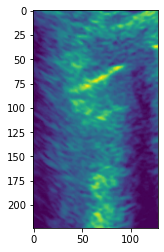

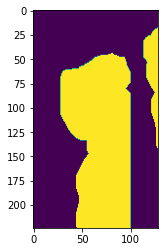

In [12]:
imgnum = 1 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

print(arrimg.shape)
print(arrlbl.min(), arrlbl.max())
roi_size = (arr.shape[0], arr.shape[1])

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])


In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=None)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=None)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 8/8 [00:00<00:00, 29.15it/s]


tensor(1)
Data Size = torch.Size([24, 1, 128, 224])
ROI Size = torch.Size([128, 224])


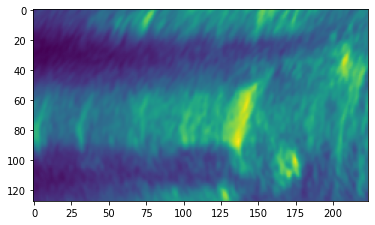

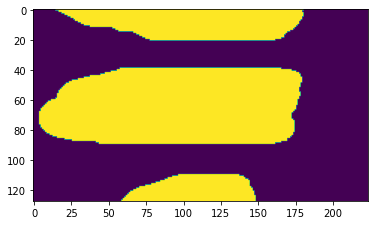

In [14]:
imgnum = 2
lbl = utils.first(train_loader[0])["label"]
m = lbl[imgnum,0,:,:].max()
print(m)
if m == 1:
    img = utils.first(train_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:])
print("Data Size =", lbl.shape)
roi_size = lbl.shape[2:]
print("ROI Size =", roi_size)

In [ ]:
device = torch.device("cuda:1")

#def get_kernels_strides():
#    sizes, spacings = [224,128], [1, 1]
#    strides, kernels = [], []

#    while True:
#        spacing_ratio = [sp / min(spacings) for sp in spacings]
#        stride = [
#            2 if ratio <= 2 and size >= 8 else 1
#            for (ratio, size) in zip(spacing_ratio, sizes)
#        ]
#        kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
#        if all(s == 1 for s in stride):
#            break
#        sizes = [i / j for i, j in zip(sizes, stride)]
#        spacings = [i * j for i, j in zip(spacings, stride)]
#        kernels.append(kernel)
#        strides.append(stride)
#    strides.insert(0, len(spacings) * [1])
#    kernels.append(len(spacings) * [3])
#    return kernels, strides

#kernels, strides = get_kernels_strides()

def vfold_train(vfold_num, train_loader, val_loader):
    #model = DynUNet(
    #    spatial_dims=2,
    #    in_channels=2,
    #    out_channels=num_classes,
    #    kernel_size=kernels,
    #    strides=strides,
    #    upsample_kernel_size=strides[1:],
    #    norm_name="instance",
    #    deep_supervision=False,  #True,
    #    #deep_supr_num=deep_supr_num[task_id],
    #)
    model = UNet(
        dimensions=2,
        in_channels=2,
        out_channels=num_classes,
        channels=(32, 64, 128, 32),
        strides=(1, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-5)
    #optimizer = torch.optim.SGD(
        #model.parameters(),
        #lr=1e-4, #learning_rate,
        #momentum=0.99,
        #weight_decay=3e-5,
        #nesterov=True,
    #)
    dice_metric = DiceMetric(include_background=False, reduction="mean")


    max_epochs = 1000
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    root_dir = "."

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        root_dir, model_filename_base+'_'+str(vfold_num)+'.pth'))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

# In[ ]:


for i in range(num_folds):
    vfold_train(i, train_loader[i], val_loader[i])


# In[ ]:

----------
0: epoch 1/1000
1/0, train_loss: 0.5910
2/0, train_loss: 0.6138
3/0, train_loss: 0.6146
4/0, train_loss: 0.6059
0 epoch 1 average loss: 0.6063
----------
0: epoch 2/1000
1/0, train_loss: 0.5989
2/0, train_loss: 0.6420
3/0, train_loss: 0.5845
4/0, train_loss: 0.5756
0 epoch 2 average loss: 0.6003
saved new best metric model
current epoch: 2 current mean dice: 0.4424
best mean dice: 0.4424 at epoch: 2
----------
0: epoch 3/1000
1/0, train_loss: 0.5766
2/0, train_loss: 0.6031
3/0, train_loss: 0.5880
4/0, train_loss: 0.6117
0 epoch 3 average loss: 0.5949
----------
0: epoch 4/1000
1/0, train_loss: 0.6013
2/0, train_loss: 0.5593
3/0, train_loss: 0.6000
4/0, train_loss: 0.5919
0 epoch 4 average loss: 0.5881
saved new best metric model
current epoch: 4 current mean dice: 0.4468
best mean dice: 0.4468 at epoch: 4
----------
0: epoch 5/1000
1/0, train_loss: 0.5875
2/0, train_loss: 0.5735
3/0, train_loss: 0.5788
4/0, train_loss: 0.5927
0 epoch 5 average loss: 0.5831
----------
0: epoc

1/0, train_loss: 0.5696
2/0, train_loss: 0.5035
3/0, train_loss: 0.5019
4/0, train_loss: 0.5484
0 epoch 41 average loss: 0.5309
----------
0: epoch 42/1000
1/0, train_loss: 0.5523
2/0, train_loss: 0.5410
3/0, train_loss: 0.5215
4/0, train_loss: 0.4997
0 epoch 42 average loss: 0.5286
saved new best metric model
current epoch: 42 current mean dice: 0.5450
best mean dice: 0.5450 at epoch: 42
----------
0: epoch 43/1000
1/0, train_loss: 0.5189
2/0, train_loss: 0.5805
3/0, train_loss: 0.5157
4/0, train_loss: 0.4979
0 epoch 43 average loss: 0.5283
----------
0: epoch 44/1000
1/0, train_loss: 0.5551
2/0, train_loss: 0.4960
3/0, train_loss: 0.5545
4/0, train_loss: 0.5094
0 epoch 44 average loss: 0.5288
saved new best metric model
current epoch: 44 current mean dice: 0.5546
best mean dice: 0.5546 at epoch: 44
----------
0: epoch 45/1000
1/0, train_loss: 0.5323
2/0, train_loss: 0.4862
3/0, train_loss: 0.5447
4/0, train_loss: 0.5425
0 epoch 45 average loss: 0.5264
----------
0: epoch 46/1000
1/0,

0 epoch 80 average loss: 0.5079
saved new best metric model
current epoch: 80 current mean dice: 0.6420
best mean dice: 0.6420 at epoch: 80
----------
0: epoch 81/1000
1/0, train_loss: 0.5392
2/0, train_loss: 0.4756
3/0, train_loss: 0.5310
4/0, train_loss: 0.4930
0 epoch 81 average loss: 0.5097
----------
0: epoch 82/1000
1/0, train_loss: 0.5160
2/0, train_loss: 0.5245
3/0, train_loss: 0.4995
4/0, train_loss: 0.5043
0 epoch 82 average loss: 0.5111
saved new best metric model
current epoch: 82 current mean dice: 0.6443
best mean dice: 0.6443 at epoch: 82
----------
0: epoch 83/1000
1/0, train_loss: 0.5376
2/0, train_loss: 0.5067
3/0, train_loss: 0.4584
4/0, train_loss: 0.5280
0 epoch 83 average loss: 0.5076
----------
0: epoch 84/1000
1/0, train_loss: 0.5153
2/0, train_loss: 0.4878
3/0, train_loss: 0.4883
4/0, train_loss: 0.5375
0 epoch 84 average loss: 0.5072
saved new best metric model
current epoch: 84 current mean dice: 0.6456
best mean dice: 0.6456 at epoch: 84
----------
0: epoch 

3/0, train_loss: 0.4806
4/0, train_loss: 0.5014
0 epoch 120 average loss: 0.4983
current epoch: 120 current mean dice: 0.6722
best mean dice: 0.6753 at epoch: 116
----------
0: epoch 121/1000
1/0, train_loss: 0.5212
2/0, train_loss: 0.4911
3/0, train_loss: 0.5010
4/0, train_loss: 0.4666
0 epoch 121 average loss: 0.4950
----------
0: epoch 122/1000
1/0, train_loss: 0.4792
2/0, train_loss: 0.5190
3/0, train_loss: 0.4684
4/0, train_loss: 0.5102
0 epoch 122 average loss: 0.4942
saved new best metric model
current epoch: 122 current mean dice: 0.6796
best mean dice: 0.6796 at epoch: 122
----------
0: epoch 123/1000
1/0, train_loss: 0.5020
2/0, train_loss: 0.4809
3/0, train_loss: 0.5278
4/0, train_loss: 0.4808
0 epoch 123 average loss: 0.4979
----------
0: epoch 124/1000
1/0, train_loss: 0.4912
2/0, train_loss: 0.4912
3/0, train_loss: 0.5049
4/0, train_loss: 0.4989
0 epoch 124 average loss: 0.4965
current epoch: 124 current mean dice: 0.6770
best mean dice: 0.6796 at epoch: 122
----------
0:

0 epoch 160 average loss: 0.4808
current epoch: 160 current mean dice: 0.7115
best mean dice: 0.7335 at epoch: 146
----------
0: epoch 161/1000
1/0, train_loss: 0.4259
2/0, train_loss: 0.4856
3/0, train_loss: 0.4890
4/0, train_loss: 0.5306
0 epoch 161 average loss: 0.4828
----------
0: epoch 162/1000
1/0, train_loss: 0.4691
2/0, train_loss: 0.4663
3/0, train_loss: 0.5224
4/0, train_loss: 0.4609
0 epoch 162 average loss: 0.4797
current epoch: 162 current mean dice: 0.7268
best mean dice: 0.7335 at epoch: 146
----------
0: epoch 163/1000
1/0, train_loss: 0.5167
2/0, train_loss: 0.4559
3/0, train_loss: 0.4961
4/0, train_loss: 0.4515
0 epoch 163 average loss: 0.4801
----------
0: epoch 164/1000
1/0, train_loss: 0.4955
2/0, train_loss: 0.4641
3/0, train_loss: 0.4670
4/0, train_loss: 0.4842
0 epoch 164 average loss: 0.4777
current epoch: 164 current mean dice: 0.7218
best mean dice: 0.7335 at epoch: 146
----------
0: epoch 165/1000
1/0, train_loss: 0.5008
2/0, train_loss: 0.4412
3/0, train_l

0 epoch 201 average loss: 0.4720
----------
0: epoch 202/1000
1/0, train_loss: 0.4658
2/0, train_loss: 0.4671
3/0, train_loss: 0.4502
4/0, train_loss: 0.5014
0 epoch 202 average loss: 0.4711
current epoch: 202 current mean dice: 0.7175
best mean dice: 0.7357 at epoch: 170
----------
0: epoch 203/1000
1/0, train_loss: 0.4824
2/0, train_loss: 0.4415
3/0, train_loss: 0.4792
4/0, train_loss: 0.4848
0 epoch 203 average loss: 0.4720
----------
0: epoch 204/1000
1/0, train_loss: 0.4495
2/0, train_loss: 0.4600
3/0, train_loss: 0.5326
4/0, train_loss: 0.4498
0 epoch 204 average loss: 0.4729
current epoch: 204 current mean dice: 0.7072
best mean dice: 0.7357 at epoch: 170
----------
0: epoch 205/1000
1/0, train_loss: 0.4842
2/0, train_loss: 0.4649
3/0, train_loss: 0.4544
4/0, train_loss: 0.4801
0 epoch 205 average loss: 0.4709
----------
0: epoch 206/1000
1/0, train_loss: 0.4459
2/0, train_loss: 0.4499
3/0, train_loss: 0.5038
4/0, train_loss: 0.4902
0 epoch 206 average loss: 0.4724
current epoch

1/0, train_loss: 0.4888
2/0, train_loss: 0.4827
3/0, train_loss: 0.4576
4/0, train_loss: 0.4399
0 epoch 243 average loss: 0.4673
----------
0: epoch 244/1000
1/0, train_loss: 0.4575
2/0, train_loss: 0.5120
3/0, train_loss: 0.4370
4/0, train_loss: 0.4460
0 epoch 244 average loss: 0.4631
current epoch: 244 current mean dice: 0.7273
best mean dice: 0.7390 at epoch: 228
----------
0: epoch 245/1000
1/0, train_loss: 0.4619
2/0, train_loss: 0.5300
3/0, train_loss: 0.4276
4/0, train_loss: 0.4472
0 epoch 245 average loss: 0.4667
----------
0: epoch 246/1000
1/0, train_loss: 0.4748
2/0, train_loss: 0.4523
3/0, train_loss: 0.4410
4/0, train_loss: 0.4922
0 epoch 246 average loss: 0.4651
current epoch: 246 current mean dice: 0.7114
best mean dice: 0.7390 at epoch: 228
----------
0: epoch 247/1000
1/0, train_loss: 0.4773
2/0, train_loss: 0.4028
3/0, train_loss: 0.4704
4/0, train_loss: 0.5176
0 epoch 247 average loss: 0.4670
----------
0: epoch 248/1000
1/0, train_loss: 0.4732
2/0, train_loss: 0.405

4/0, train_loss: 0.4520
0 epoch 284 average loss: 0.4582
current epoch: 284 current mean dice: 0.7193
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 285/1000
1/0, train_loss: 0.4298
2/0, train_loss: 0.4309
3/0, train_loss: 0.4989
4/0, train_loss: 0.4895
0 epoch 285 average loss: 0.4623
----------
0: epoch 286/1000
1/0, train_loss: 0.4257
2/0, train_loss: 0.4711
3/0, train_loss: 0.4880
4/0, train_loss: 0.4551
0 epoch 286 average loss: 0.4600
current epoch: 286 current mean dice: 0.7215
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 287/1000
1/0, train_loss: 0.4787
2/0, train_loss: 0.4903
3/0, train_loss: 0.4434
4/0, train_loss: 0.4297
0 epoch 287 average loss: 0.4605
----------
0: epoch 288/1000
1/0, train_loss: 0.4436
2/0, train_loss: 0.4759
3/0, train_loss: 0.4994
4/0, train_loss: 0.4137
0 epoch 288 average loss: 0.4582
current epoch: 288 current mean dice: 0.7263
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 289/1000
1/0, train_loss: 0.4783
2/0, train_l

0 epoch 325 average loss: 0.4546
----------
0: epoch 326/1000
1/0, train_loss: 0.4339
2/0, train_loss: 0.4276
3/0, train_loss: 0.4678
4/0, train_loss: 0.4945
0 epoch 326 average loss: 0.4559
current epoch: 326 current mean dice: 0.7241
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 327/1000
1/0, train_loss: 0.4520
2/0, train_loss: 0.4542
3/0, train_loss: 0.4733
4/0, train_loss: 0.4250
0 epoch 327 average loss: 0.4511
----------
0: epoch 328/1000
1/0, train_loss: 0.4573
2/0, train_loss: 0.4604
3/0, train_loss: 0.4375
4/0, train_loss: 0.4612
0 epoch 328 average loss: 0.4541
current epoch: 328 current mean dice: 0.7361
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 329/1000
1/0, train_loss: 0.4829
2/0, train_loss: 0.4074
3/0, train_loss: 0.4649
4/0, train_loss: 0.4510
0 epoch 329 average loss: 0.4515
----------
0: epoch 330/1000
1/0, train_loss: 0.4293
2/0, train_loss: 0.4944
3/0, train_loss: 0.4632
4/0, train_loss: 0.4324
0 epoch 330 average loss: 0.4548
current epoch

1/0, train_loss: 0.4415
2/0, train_loss: 0.4617
3/0, train_loss: 0.4366
4/0, train_loss: 0.4459
0 epoch 367 average loss: 0.4464
----------
0: epoch 368/1000
1/0, train_loss: 0.4835
2/0, train_loss: 0.4138
3/0, train_loss: 0.4881
4/0, train_loss: 0.4196
0 epoch 368 average loss: 0.4512
current epoch: 368 current mean dice: 0.7297
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 369/1000
1/0, train_loss: 0.4174
2/0, train_loss: 0.4446
3/0, train_loss: 0.4585
4/0, train_loss: 0.4890
0 epoch 369 average loss: 0.4524
----------
0: epoch 370/1000
1/0, train_loss: 0.4645
2/0, train_loss: 0.4145
3/0, train_loss: 0.4683
4/0, train_loss: 0.4431
0 epoch 370 average loss: 0.4476
current epoch: 370 current mean dice: 0.7217
best mean dice: 0.7415 at epoch: 276
----------
0: epoch 371/1000
1/0, train_loss: 0.4362
2/0, train_loss: 0.4370
3/0, train_loss: 0.4948
4/0, train_loss: 0.4249
0 epoch 371 average loss: 0.4482
----------
0: epoch 372/1000
1/0, train_loss: 0.4590
2/0, train_loss: 0.411

1/0, train_loss: 0.4636
2/0, train_loss: 0.3997
3/0, train_loss: 0.4413
4/0, train_loss: 0.4784
0 epoch 408 average loss: 0.4457
current epoch: 408 current mean dice: 0.7445
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 409/1000
1/0, train_loss: 0.3845
2/0, train_loss: 0.4580
3/0, train_loss: 0.4254
4/0, train_loss: 0.5198
0 epoch 409 average loss: 0.4469
----------
0: epoch 410/1000
1/0, train_loss: 0.4355
2/0, train_loss: 0.5766
3/0, train_loss: 0.3792
4/0, train_loss: 0.4027
0 epoch 410 average loss: 0.4485
current epoch: 410 current mean dice: 0.7130
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 411/1000
1/0, train_loss: 0.4669
2/0, train_loss: 0.4288
3/0, train_loss: 0.4769
4/0, train_loss: 0.4043
0 epoch 411 average loss: 0.4442
----------
0: epoch 412/1000
1/0, train_loss: 0.4816
2/0, train_loss: 0.4082
3/0, train_loss: 0.4444
4/0, train_loss: 0.4379
0 epoch 412 average loss: 0.4430
current epoch: 412 current mean dice: 0.7424
best mean dice: 0.7541 at epoc

1/0, train_loss: 0.3892
2/0, train_loss: 0.4329
3/0, train_loss: 0.4859
4/0, train_loss: 0.4409
0 epoch 449 average loss: 0.4372
----------
0: epoch 450/1000
1/0, train_loss: 0.4925
2/0, train_loss: 0.4368
3/0, train_loss: 0.4015
4/0, train_loss: 0.4284
0 epoch 450 average loss: 0.4398
current epoch: 450 current mean dice: 0.7339
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 451/1000
1/0, train_loss: 0.4017
2/0, train_loss: 0.4544
3/0, train_loss: 0.4721
4/0, train_loss: 0.4228
0 epoch 451 average loss: 0.4377
----------
0: epoch 452/1000
1/0, train_loss: 0.4029
2/0, train_loss: 0.4488
3/0, train_loss: 0.4174
4/0, train_loss: 0.4949
0 epoch 452 average loss: 0.4410
current epoch: 452 current mean dice: 0.7364
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 453/1000
1/0, train_loss: 0.4151
2/0, train_loss: 0.4773
3/0, train_loss: 0.4087
4/0, train_loss: 0.4565
0 epoch 453 average loss: 0.4394
----------
0: epoch 454/1000
1/0, train_loss: 0.4783
2/0, train_loss: 0.477

0 epoch 490 average loss: 0.4339
current epoch: 490 current mean dice: 0.7319
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 491/1000
1/0, train_loss: 0.4967
2/0, train_loss: 0.4247
3/0, train_loss: 0.4015
4/0, train_loss: 0.4221
0 epoch 491 average loss: 0.4363
----------
0: epoch 492/1000
1/0, train_loss: 0.4403
2/0, train_loss: 0.3559
3/0, train_loss: 0.4906
4/0, train_loss: 0.4617
0 epoch 492 average loss: 0.4371
current epoch: 492 current mean dice: 0.7380
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 493/1000
1/0, train_loss: 0.4696
2/0, train_loss: 0.5164
3/0, train_loss: 0.4129
4/0, train_loss: 0.3497
0 epoch 493 average loss: 0.4372
----------
0: epoch 494/1000
1/0, train_loss: 0.5328
2/0, train_loss: 0.4061
3/0, train_loss: 0.4030
4/0, train_loss: 0.3974
0 epoch 494 average loss: 0.4348
current epoch: 494 current mean dice: 0.7279
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 495/1000
1/0, train_loss: 0.4116
2/0, train_loss: 0.4818
3/0, train_l

0 epoch 531 average loss: 0.4307
----------
0: epoch 532/1000
1/0, train_loss: 0.5148
2/0, train_loss: 0.3888
3/0, train_loss: 0.4023
4/0, train_loss: 0.4292
0 epoch 532 average loss: 0.4338
current epoch: 532 current mean dice: 0.7388
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 533/1000
1/0, train_loss: 0.4327
2/0, train_loss: 0.4836
3/0, train_loss: 0.3826
4/0, train_loss: 0.4234
0 epoch 533 average loss: 0.4306
----------
0: epoch 534/1000
1/0, train_loss: 0.4158
2/0, train_loss: 0.4428
3/0, train_loss: 0.3824
4/0, train_loss: 0.4983
0 epoch 534 average loss: 0.4348
current epoch: 534 current mean dice: 0.7283
best mean dice: 0.7541 at epoch: 380
----------
0: epoch 535/1000
1/0, train_loss: 0.3909
2/0, train_loss: 0.4157
3/0, train_loss: 0.4361
4/0, train_loss: 0.4853
0 epoch 535 average loss: 0.4320
----------
0: epoch 536/1000
1/0, train_loss: 0.4493
2/0, train_loss: 0.3598
3/0, train_loss: 0.4690
4/0, train_loss: 0.4514
0 epoch 536 average loss: 0.4324
current epoch

1/0, train_loss: 0.3884
2/0, train_loss: 0.5312
3/0, train_loss: 0.3525
4/0, train_loss: 0.4525
0 epoch 573 average loss: 0.4312
----------
0: epoch 574/1000
1/0, train_loss: 0.4239
2/0, train_loss: 0.4075
3/0, train_loss: 0.4061
4/0, train_loss: 0.4781
0 epoch 574 average loss: 0.4289
current epoch: 574 current mean dice: 0.7462
best mean dice: 0.7557 at epoch: 548
----------
0: epoch 575/1000
1/0, train_loss: 0.4252
2/0, train_loss: 0.4243
3/0, train_loss: 0.3949
4/0, train_loss: 0.4725
0 epoch 575 average loss: 0.4292
----------
0: epoch 576/1000
1/0, train_loss: 0.4151
2/0, train_loss: 0.5045
3/0, train_loss: 0.4052
4/0, train_loss: 0.3775
0 epoch 576 average loss: 0.4256
current epoch: 576 current mean dice: 0.7446
best mean dice: 0.7557 at epoch: 548
----------
0: epoch 577/1000
1/0, train_loss: 0.4014
2/0, train_loss: 0.3836
3/0, train_loss: 0.4689
4/0, train_loss: 0.4582
0 epoch 577 average loss: 0.4280
----------
0: epoch 578/1000
1/0, train_loss: 0.4060
2/0, train_loss: 0.450

4/0, train_loss: 0.4271
0 epoch 614 average loss: 0.4237
current epoch: 614 current mean dice: 0.7408
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 615/1000
1/0, train_loss: 0.3616
2/0, train_loss: 0.4387
3/0, train_loss: 0.5066
4/0, train_loss: 0.3874
0 epoch 615 average loss: 0.4236
----------
0: epoch 616/1000
1/0, train_loss: 0.4125
2/0, train_loss: 0.4044
3/0, train_loss: 0.4794
4/0, train_loss: 0.3923
0 epoch 616 average loss: 0.4222
current epoch: 616 current mean dice: 0.7341
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 617/1000
1/0, train_loss: 0.4009
2/0, train_loss: 0.4182
3/0, train_loss: 0.4253
4/0, train_loss: 0.4514
0 epoch 617 average loss: 0.4239
----------
0: epoch 618/1000
1/0, train_loss: 0.5048
2/0, train_loss: 0.3624
3/0, train_loss: 0.4488
4/0, train_loss: 0.3999
0 epoch 618 average loss: 0.4290
current epoch: 618 current mean dice: 0.7515
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 619/1000
1/0, train_loss: 0.3990
2/0, train_l

0 epoch 655 average loss: 0.4180
----------
0: epoch 656/1000
1/0, train_loss: 0.3889
2/0, train_loss: 0.4075
3/0, train_loss: 0.4568
4/0, train_loss: 0.4205
0 epoch 656 average loss: 0.4184
current epoch: 656 current mean dice: 0.7188
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 657/1000
1/0, train_loss: 0.4532
2/0, train_loss: 0.4105
3/0, train_loss: 0.3916
4/0, train_loss: 0.4279
0 epoch 657 average loss: 0.4208
----------
0: epoch 658/1000
1/0, train_loss: 0.4059
2/0, train_loss: 0.3546
3/0, train_loss: 0.4335
4/0, train_loss: 0.4938
0 epoch 658 average loss: 0.4220
current epoch: 658 current mean dice: 0.7447
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 659/1000
1/0, train_loss: 0.4176
2/0, train_loss: 0.4115
3/0, train_loss: 0.4395
4/0, train_loss: 0.4026
0 epoch 659 average loss: 0.4178
----------
0: epoch 660/1000
1/0, train_loss: 0.4255
2/0, train_loss: 0.4162
3/0, train_loss: 0.4274
4/0, train_loss: 0.4015
0 epoch 660 average loss: 0.4176
current epoch

1/0, train_loss: 0.4229
2/0, train_loss: 0.4342
3/0, train_loss: 0.4476
4/0, train_loss: 0.3450
0 epoch 697 average loss: 0.4124
----------
0: epoch 698/1000
1/0, train_loss: 0.4396
2/0, train_loss: 0.3463
3/0, train_loss: 0.4770
4/0, train_loss: 0.4077
0 epoch 698 average loss: 0.4177
current epoch: 698 current mean dice: 0.7180
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 699/1000
1/0, train_loss: 0.3923
2/0, train_loss: 0.4701
3/0, train_loss: 0.4803
4/0, train_loss: 0.3255
0 epoch 699 average loss: 0.4170
----------
0: epoch 700/1000
1/0, train_loss: 0.4374
2/0, train_loss: 0.4106
3/0, train_loss: 0.4347
4/0, train_loss: 0.3747
0 epoch 700 average loss: 0.4144
current epoch: 700 current mean dice: 0.7376
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 701/1000
1/0, train_loss: 0.4537
2/0, train_loss: 0.3887
3/0, train_loss: 0.4125
4/0, train_loss: 0.3992
0 epoch 701 average loss: 0.4135
----------
0: epoch 702/1000
1/0, train_loss: 0.4579
2/0, train_loss: 0.417

0 epoch 738 average loss: 0.4108
current epoch: 738 current mean dice: 0.7039
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 739/1000
1/0, train_loss: 0.3920
2/0, train_loss: 0.4419
3/0, train_loss: 0.4349
4/0, train_loss: 0.3696
0 epoch 739 average loss: 0.4096
----------
0: epoch 740/1000
1/0, train_loss: 0.4050
2/0, train_loss: 0.3946
3/0, train_loss: 0.4117
4/0, train_loss: 0.4226
0 epoch 740 average loss: 0.4085
current epoch: 740 current mean dice: 0.7250
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 741/1000
1/0, train_loss: 0.4065
2/0, train_loss: 0.3758
3/0, train_loss: 0.3993
4/0, train_loss: 0.4722
0 epoch 741 average loss: 0.4135
----------
0: epoch 742/1000
1/0, train_loss: 0.4079
2/0, train_loss: 0.3631
3/0, train_loss: 0.4283
4/0, train_loss: 0.4493
0 epoch 742 average loss: 0.4121
current epoch: 742 current mean dice: 0.7300
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 743/1000
1/0, train_loss: 0.3996
2/0, train_loss: 0.4931
3/0, train_l

0 epoch 779 average loss: 0.4117
----------
0: epoch 780/1000
1/0, train_loss: 0.3668
2/0, train_loss: 0.4742
3/0, train_loss: 0.3727
4/0, train_loss: 0.4223
0 epoch 780 average loss: 0.4090
current epoch: 780 current mean dice: 0.7394
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 781/1000
1/0, train_loss: 0.4411
2/0, train_loss: 0.3810
3/0, train_loss: 0.4302
4/0, train_loss: 0.3721
0 epoch 781 average loss: 0.4061
----------
0: epoch 782/1000
1/0, train_loss: 0.3677
2/0, train_loss: 0.3941
3/0, train_loss: 0.4007
4/0, train_loss: 0.4672
0 epoch 782 average loss: 0.4074
current epoch: 782 current mean dice: 0.7186
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 783/1000
1/0, train_loss: 0.4161
2/0, train_loss: 0.4614
3/0, train_loss: 0.3348
4/0, train_loss: 0.4334
0 epoch 783 average loss: 0.4114
----------
0: epoch 784/1000
1/0, train_loss: 0.3858
2/0, train_loss: 0.4865
3/0, train_loss: 0.3700
4/0, train_loss: 0.3760
0 epoch 784 average loss: 0.4046
current epoch

1/0, train_loss: 0.3868
2/0, train_loss: 0.3671
3/0, train_loss: 0.4022
4/0, train_loss: 0.4658
0 epoch 821 average loss: 0.4055
----------
0: epoch 822/1000
1/0, train_loss: 0.3539
2/0, train_loss: 0.4148
3/0, train_loss: 0.5033
4/0, train_loss: 0.3461
0 epoch 822 average loss: 0.4045
current epoch: 822 current mean dice: 0.7283
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 823/1000
1/0, train_loss: 0.3755
2/0, train_loss: 0.4641
3/0, train_loss: 0.4137
4/0, train_loss: 0.3490
0 epoch 823 average loss: 0.4006
----------
0: epoch 824/1000
1/0, train_loss: 0.3783
2/0, train_loss: 0.4224
3/0, train_loss: 0.4350
4/0, train_loss: 0.3777
0 epoch 824 average loss: 0.4034
current epoch: 824 current mean dice: 0.7139
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 825/1000
1/0, train_loss: 0.3769
2/0, train_loss: 0.4747
3/0, train_loss: 0.3141
4/0, train_loss: 0.4708
0 epoch 825 average loss: 0.4091
----------
0: epoch 826/1000
1/0, train_loss: 0.3991
2/0, train_loss: 0.454

0 epoch 862 average loss: 0.4047
current epoch: 862 current mean dice: 0.7350
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 863/1000
1/0, train_loss: 0.4698
2/0, train_loss: 0.3235
3/0, train_loss: 0.4148
4/0, train_loss: 0.3952
0 epoch 863 average loss: 0.4008
----------
0: epoch 864/1000
1/0, train_loss: 0.4053
2/0, train_loss: 0.4037
3/0, train_loss: 0.3607
4/0, train_loss: 0.4367
0 epoch 864 average loss: 0.4016
current epoch: 864 current mean dice: 0.7014
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 865/1000
1/0, train_loss: 0.4431
2/0, train_loss: 0.3436
3/0, train_loss: 0.4098
4/0, train_loss: 0.4057
0 epoch 865 average loss: 0.4005
----------
0: epoch 866/1000
1/0, train_loss: 0.4487
2/0, train_loss: 0.4480
3/0, train_loss: 0.3504
4/0, train_loss: 0.3556
0 epoch 866 average loss: 0.4007
current epoch: 866 current mean dice: 0.7241
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 867/1000
1/0, train_loss: 0.4458
2/0, train_loss: 0.4030
3/0, train_l

0 epoch 903 average loss: 0.4012
----------
0: epoch 904/1000
1/0, train_loss: 0.4318
2/0, train_loss: 0.3711
3/0, train_loss: 0.3912
4/0, train_loss: 0.4065
0 epoch 904 average loss: 0.4001
current epoch: 904 current mean dice: 0.7344
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 905/1000
1/0, train_loss: 0.4541
2/0, train_loss: 0.3768
3/0, train_loss: 0.4038
4/0, train_loss: 0.3482
0 epoch 905 average loss: 0.3957
----------
0: epoch 906/1000
1/0, train_loss: 0.4749
2/0, train_loss: 0.4139
3/0, train_loss: 0.3579
4/0, train_loss: 0.3465
0 epoch 906 average loss: 0.3983
current epoch: 906 current mean dice: 0.6852
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 907/1000
1/0, train_loss: 0.3852
2/0, train_loss: 0.4533
3/0, train_loss: 0.3917
4/0, train_loss: 0.3531
0 epoch 907 average loss: 0.3958
----------
0: epoch 908/1000
1/0, train_loss: 0.4137
2/0, train_loss: 0.4024
3/0, train_loss: 0.4055
4/0, train_loss: 0.3686
0 epoch 908 average loss: 0.3975
current epoch

1/0, train_loss: 0.3887
2/0, train_loss: 0.3871
3/0, train_loss: 0.3911
4/0, train_loss: 0.4145
0 epoch 945 average loss: 0.3953
----------
0: epoch 946/1000
1/0, train_loss: 0.4385
2/0, train_loss: 0.3618
3/0, train_loss: 0.3646
4/0, train_loss: 0.4114
0 epoch 946 average loss: 0.3941
current epoch: 946 current mean dice: 0.7095
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 947/1000
1/0, train_loss: 0.3740
2/0, train_loss: 0.3663
3/0, train_loss: 0.4112
4/0, train_loss: 0.4227
0 epoch 947 average loss: 0.3935
----------
0: epoch 948/1000
1/0, train_loss: 0.3782
2/0, train_loss: 0.3834
3/0, train_loss: 0.3827
4/0, train_loss: 0.4331
0 epoch 948 average loss: 0.3943
current epoch: 948 current mean dice: 0.7312
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 949/1000
1/0, train_loss: 0.4150
2/0, train_loss: 0.3923
3/0, train_loss: 0.3741
4/0, train_loss: 0.3956
0 epoch 949 average loss: 0.3943
----------
0: epoch 950/1000
1/0, train_loss: 0.4130
2/0, train_loss: 0.465

0 epoch 986 average loss: 0.3963
current epoch: 986 current mean dice: 0.7240
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 987/1000
1/0, train_loss: 0.4112
2/0, train_loss: 0.3894
3/0, train_loss: 0.3846
4/0, train_loss: 0.3756
0 epoch 987 average loss: 0.3902
----------
0: epoch 988/1000
1/0, train_loss: 0.4538
2/0, train_loss: 0.4024
3/0, train_loss: 0.3441
4/0, train_loss: 0.3635
0 epoch 988 average loss: 0.3909
current epoch: 988 current mean dice: 0.7183
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 989/1000
1/0, train_loss: 0.4230
2/0, train_loss: 0.3723
3/0, train_loss: 0.3469
4/0, train_loss: 0.4328
0 epoch 989 average loss: 0.3938
----------
0: epoch 990/1000
1/0, train_loss: 0.3562
2/0, train_loss: 0.3858
3/0, train_loss: 0.4784
4/0, train_loss: 0.3462
0 epoch 990 average loss: 0.3917
current epoch: 990 current mean dice: 0.7003
best mean dice: 0.7600 at epoch: 582
----------
0: epoch 991/1000
1/0, train_loss: 0.3879
2/0, train_loss: 0.4222
3/0, train_l

1 epoch 26 average loss: 0.4508
saved new best metric model
current epoch: 26 current mean dice: 0.6002
best mean dice: 0.6002 at epoch: 26
----------
1: epoch 27/1000
1/0, train_loss: 0.4966
2/0, train_loss: 0.4453
3/0, train_loss: 0.4114
4/0, train_loss: 0.4546
1 epoch 27 average loss: 0.4520
----------
1: epoch 28/1000
1/0, train_loss: 0.4801
2/0, train_loss: 0.4569
3/0, train_loss: 0.4453
4/0, train_loss: 0.4146
1 epoch 28 average loss: 0.4492
saved new best metric model
current epoch: 28 current mean dice: 0.6093
best mean dice: 0.6093 at epoch: 28
----------
1: epoch 29/1000
1/0, train_loss: 0.4976
2/0, train_loss: 0.4088
3/0, train_loss: 0.4254
4/0, train_loss: 0.4630
1 epoch 29 average loss: 0.4487
----------
1: epoch 30/1000
1/0, train_loss: 0.4095
2/0, train_loss: 0.4768
3/0, train_loss: 0.4679
4/0, train_loss: 0.4121
1 epoch 30 average loss: 0.4416
saved new best metric model
current epoch: 30 current mean dice: 0.6150
best mean dice: 0.6150 at epoch: 30
----------
1: epoch 

3/0, train_loss: 0.4066
4/0, train_loss: 0.4574
1 epoch 67 average loss: 0.4190
----------
1: epoch 68/1000
1/0, train_loss: 0.4034
2/0, train_loss: 0.4371
3/0, train_loss: 0.3599
4/0, train_loss: 0.4587
1 epoch 68 average loss: 0.4148
saved new best metric model
current epoch: 68 current mean dice: 0.6297
best mean dice: 0.6297 at epoch: 68
----------
1: epoch 69/1000
1/0, train_loss: 0.4080
2/0, train_loss: 0.4306
3/0, train_loss: 0.3903
4/0, train_loss: 0.4114
1 epoch 69 average loss: 0.4101
----------
1: epoch 70/1000
1/0, train_loss: 0.4587
2/0, train_loss: 0.4312
3/0, train_loss: 0.3347
4/0, train_loss: 0.4321
1 epoch 70 average loss: 0.4142
current epoch: 70 current mean dice: 0.6189
best mean dice: 0.6297 at epoch: 68
----------
1: epoch 71/1000
1/0, train_loss: 0.3448
2/0, train_loss: 0.4760
3/0, train_loss: 0.3991
4/0, train_loss: 0.4378
1 epoch 71 average loss: 0.4144
----------
1: epoch 72/1000
1/0, train_loss: 0.3861
2/0, train_loss: 0.4095
3/0, train_loss: 0.4084
4/0, tra

1/0, train_loss: 0.3560
2/0, train_loss: 0.4176
3/0, train_loss: 0.4142
4/0, train_loss: 0.4131
1 epoch 108 average loss: 0.4002
saved new best metric model
current epoch: 108 current mean dice: 0.6658
best mean dice: 0.6658 at epoch: 108
----------
1: epoch 109/1000
1/0, train_loss: 0.4042
2/0, train_loss: 0.4083
3/0, train_loss: 0.3637
4/0, train_loss: 0.4416
1 epoch 109 average loss: 0.4045
----------
1: epoch 110/1000
1/0, train_loss: 0.4445
2/0, train_loss: 0.4027
3/0, train_loss: 0.3920
4/0, train_loss: 0.3606
1 epoch 110 average loss: 0.4000
current epoch: 110 current mean dice: 0.6649
best mean dice: 0.6658 at epoch: 108
----------
1: epoch 111/1000
1/0, train_loss: 0.3977
2/0, train_loss: 0.4716
3/0, train_loss: 0.3972
4/0, train_loss: 0.3208
1 epoch 111 average loss: 0.3968
----------
1: epoch 112/1000
1/0, train_loss: 0.4396
2/0, train_loss: 0.4095
3/0, train_loss: 0.4280
4/0, train_loss: 0.3085
1 epoch 112 average loss: 0.3964
current epoch: 112 current mean dice: 0.6630
be

1 epoch 148 average loss: 0.3896
current epoch: 148 current mean dice: 0.6673
best mean dice: 0.6891 at epoch: 134
----------
1: epoch 149/1000
1/0, train_loss: 0.3673
2/0, train_loss: 0.3367
3/0, train_loss: 0.4687
4/0, train_loss: 0.4038
1 epoch 149 average loss: 0.3941
----------
1: epoch 150/1000
1/0, train_loss: 0.3697
2/0, train_loss: 0.3563
3/0, train_loss: 0.4436
4/0, train_loss: 0.3943
1 epoch 150 average loss: 0.3910
current epoch: 150 current mean dice: 0.6803
best mean dice: 0.6891 at epoch: 134
----------
1: epoch 151/1000
1/0, train_loss: 0.4001
2/0, train_loss: 0.3566
3/0, train_loss: 0.3758
4/0, train_loss: 0.4402
1 epoch 151 average loss: 0.3932
----------
1: epoch 152/1000
1/0, train_loss: 0.3699
2/0, train_loss: 0.4392
3/0, train_loss: 0.3770
4/0, train_loss: 0.3722
1 epoch 152 average loss: 0.3896
current epoch: 152 current mean dice: 0.6688
best mean dice: 0.6891 at epoch: 134
----------
1: epoch 153/1000
1/0, train_loss: 0.3788
2/0, train_loss: 0.3531
3/0, train_l

4/0, train_loss: 0.3529
1 epoch 189 average loss: 0.3808
----------
1: epoch 190/1000
1/0, train_loss: 0.3709
2/0, train_loss: 0.3848
3/0, train_loss: 0.3793
4/0, train_loss: 0.3989
1 epoch 190 average loss: 0.3835
current epoch: 190 current mean dice: 0.6893
best mean dice: 0.7012 at epoch: 172
----------
1: epoch 191/1000
1/0, train_loss: 0.3918
2/0, train_loss: 0.3956
3/0, train_loss: 0.4063
4/0, train_loss: 0.3238
1 epoch 191 average loss: 0.3794
----------
1: epoch 192/1000
1/0, train_loss: 0.3641
2/0, train_loss: 0.3732
3/0, train_loss: 0.3927
4/0, train_loss: 0.4064
1 epoch 192 average loss: 0.3841
current epoch: 192 current mean dice: 0.6967
best mean dice: 0.7012 at epoch: 172
----------
1: epoch 193/1000
1/0, train_loss: 0.3668
2/0, train_loss: 0.3670
3/0, train_loss: 0.3916
4/0, train_loss: 0.4042
1 epoch 193 average loss: 0.3824
----------
1: epoch 194/1000
1/0, train_loss: 0.4114
2/0, train_loss: 0.4185
3/0, train_loss: 0.3527
4/0, train_loss: 0.3364
1 epoch 194 average lo

current epoch: 230 current mean dice: 0.7000
best mean dice: 0.7058 at epoch: 196
----------
1: epoch 231/1000
1/0, train_loss: 0.3702
2/0, train_loss: 0.4178
3/0, train_loss: 0.3256
4/0, train_loss: 0.4222
1 epoch 231 average loss: 0.3840
----------
1: epoch 232/1000
1/0, train_loss: 0.3280
2/0, train_loss: 0.4264
3/0, train_loss: 0.3858
4/0, train_loss: 0.3761
1 epoch 232 average loss: 0.3791
current epoch: 232 current mean dice: 0.6921
best mean dice: 0.7058 at epoch: 196
----------
1: epoch 233/1000
1/0, train_loss: 0.3881
2/0, train_loss: 0.3268
3/0, train_loss: 0.3575
4/0, train_loss: 0.4575
1 epoch 233 average loss: 0.3825
----------
1: epoch 234/1000
1/0, train_loss: 0.3679
2/0, train_loss: 0.3500
3/0, train_loss: 0.3697
4/0, train_loss: 0.4399
1 epoch 234 average loss: 0.3818
current epoch: 234 current mean dice: 0.6882
best mean dice: 0.7058 at epoch: 196
----------
1: epoch 235/1000
1/0, train_loss: 0.4305
2/0, train_loss: 0.3321
3/0, train_loss: 0.3753
4/0, train_loss: 0.37

1/0, train_loss: 0.3763
2/0, train_loss: 0.3947
3/0, train_loss: 0.3529
4/0, train_loss: 0.3699
1 epoch 272 average loss: 0.3734
current epoch: 272 current mean dice: 0.7043
best mean dice: 0.7058 at epoch: 196
----------
1: epoch 273/1000
1/0, train_loss: 0.3624
2/0, train_loss: 0.3836
3/0, train_loss: 0.4011
4/0, train_loss: 0.3292
1 epoch 273 average loss: 0.3691
----------
1: epoch 274/1000
1/0, train_loss: 0.3214
2/0, train_loss: 0.3315
3/0, train_loss: 0.4158
4/0, train_loss: 0.4361
1 epoch 274 average loss: 0.3762
saved new best metric model
current epoch: 274 current mean dice: 0.7161
best mean dice: 0.7161 at epoch: 274
----------
1: epoch 275/1000
1/0, train_loss: 0.4058
2/0, train_loss: 0.3406
3/0, train_loss: 0.4055
4/0, train_loss: 0.3527
1 epoch 275 average loss: 0.3762
----------
1: epoch 276/1000
1/0, train_loss: 0.3575
2/0, train_loss: 0.3988
3/0, train_loss: 0.3350
4/0, train_loss: 0.4124
1 epoch 276 average loss: 0.3759
current epoch: 276 current mean dice: 0.6855
be

1/0, train_loss: 0.4040
2/0, train_loss: 0.3473
3/0, train_loss: 0.3404
4/0, train_loss: 0.4094
1 epoch 313 average loss: 0.3753
----------
1: epoch 314/1000
1/0, train_loss: 0.3989
2/0, train_loss: 0.3430
3/0, train_loss: 0.3646
4/0, train_loss: 0.3667
1 epoch 314 average loss: 0.3683
saved new best metric model
current epoch: 314 current mean dice: 0.7243
best mean dice: 0.7243 at epoch: 314
----------
1: epoch 315/1000
1/0, train_loss: 0.3661
2/0, train_loss: 0.3496
3/0, train_loss: 0.3738
4/0, train_loss: 0.3976
1 epoch 315 average loss: 0.3718
----------
1: epoch 316/1000
1/0, train_loss: 0.3995
2/0, train_loss: 0.3419
3/0, train_loss: 0.3459
4/0, train_loss: 0.4037
1 epoch 316 average loss: 0.3728
current epoch: 316 current mean dice: 0.7226
best mean dice: 0.7243 at epoch: 314
----------
1: epoch 317/1000
1/0, train_loss: 0.3545
2/0, train_loss: 0.3796
3/0, train_loss: 0.4142
4/0, train_loss: 0.3157
1 epoch 317 average loss: 0.3660
----------
1: epoch 318/1000
1/0, train_loss: 0

1/0, train_loss: 0.3312
2/0, train_loss: 0.3736
3/0, train_loss: 0.3500
4/0, train_loss: 0.4255
1 epoch 354 average loss: 0.3701
current epoch: 354 current mean dice: 0.7128
best mean dice: 0.7343 at epoch: 352
----------
1: epoch 355/1000
1/0, train_loss: 0.3806
2/0, train_loss: 0.3608
3/0, train_loss: 0.3697
4/0, train_loss: 0.3425
1 epoch 355 average loss: 0.3634
----------
1: epoch 356/1000
1/0, train_loss: 0.3917
2/0, train_loss: 0.3591
3/0, train_loss: 0.3208
4/0, train_loss: 0.3811
1 epoch 356 average loss: 0.3632
current epoch: 356 current mean dice: 0.7190
best mean dice: 0.7343 at epoch: 352
----------
1: epoch 357/1000
1/0, train_loss: 0.3117
2/0, train_loss: 0.3447
3/0, train_loss: 0.4220
4/0, train_loss: 0.3840
1 epoch 357 average loss: 0.3656
----------
1: epoch 358/1000
1/0, train_loss: 0.3414
2/0, train_loss: 0.4140
3/0, train_loss: 0.3993
4/0, train_loss: 0.3107
1 epoch 358 average loss: 0.3664
current epoch: 358 current mean dice: 0.7243
best mean dice: 0.7343 at epoc

1/0, train_loss: 0.3924
2/0, train_loss: 0.3521
3/0, train_loss: 0.3754
4/0, train_loss: 0.3239
1 epoch 395 average loss: 0.3609
----------
1: epoch 396/1000
1/0, train_loss: 0.3664
2/0, train_loss: 0.3640
3/0, train_loss: 0.3609
4/0, train_loss: 0.3473
1 epoch 396 average loss: 0.3597
current epoch: 396 current mean dice: 0.7205
best mean dice: 0.7354 at epoch: 374
----------
1: epoch 397/1000
1/0, train_loss: 0.3558
2/0, train_loss: 0.3827
3/0, train_loss: 0.3864
4/0, train_loss: 0.2986
1 epoch 397 average loss: 0.3559
----------
1: epoch 398/1000
1/0, train_loss: 0.3727
2/0, train_loss: 0.3940
3/0, train_loss: 0.3159
4/0, train_loss: 0.3627
1 epoch 398 average loss: 0.3613
current epoch: 398 current mean dice: 0.7318
best mean dice: 0.7354 at epoch: 374
----------
1: epoch 399/1000
1/0, train_loss: 0.3563
2/0, train_loss: 0.3443
3/0, train_loss: 0.3809
4/0, train_loss: 0.3599
1 epoch 399 average loss: 0.3604
----------
1: epoch 400/1000
1/0, train_loss: 0.3077
2/0, train_loss: 0.413

1/0, train_loss: 0.3154
2/0, train_loss: 0.4193
3/0, train_loss: 0.3288
4/0, train_loss: 0.3848
1 epoch 436 average loss: 0.3621
current epoch: 436 current mean dice: 0.7465
best mean dice: 0.7509 at epoch: 430
----------
1: epoch 437/1000
1/0, train_loss: 0.3777
2/0, train_loss: 0.3090
3/0, train_loss: 0.3879
4/0, train_loss: 0.3383
1 epoch 437 average loss: 0.3532
----------
1: epoch 438/1000
1/0, train_loss: 0.3627
2/0, train_loss: 0.3730
3/0, train_loss: 0.3207
4/0, train_loss: 0.3777
1 epoch 438 average loss: 0.3585
current epoch: 438 current mean dice: 0.7365
best mean dice: 0.7509 at epoch: 430
----------
1: epoch 439/1000
1/0, train_loss: 0.4099
2/0, train_loss: 0.3670
3/0, train_loss: 0.3250
4/0, train_loss: 0.3265
1 epoch 439 average loss: 0.3571
----------
1: epoch 440/1000
1/0, train_loss: 0.3364
2/0, train_loss: 0.3931
3/0, train_loss: 0.3544
4/0, train_loss: 0.3509
1 epoch 440 average loss: 0.3587
current epoch: 440 current mean dice: 0.7327
best mean dice: 0.7509 at epoc

1/0, train_loss: 0.3470
2/0, train_loss: 0.3147
3/0, train_loss: 0.3612
4/0, train_loss: 0.4261
1 epoch 477 average loss: 0.3623
----------
1: epoch 478/1000
1/0, train_loss: 0.2759
2/0, train_loss: 0.4436
3/0, train_loss: 0.3860
4/0, train_loss: 0.3102
1 epoch 478 average loss: 0.3540
current epoch: 478 current mean dice: 0.7422
best mean dice: 0.7550 at epoch: 442
----------
1: epoch 479/1000
1/0, train_loss: 0.3874
2/0, train_loss: 0.4170
3/0, train_loss: 0.3181
4/0, train_loss: 0.2742
1 epoch 479 average loss: 0.3492
----------
1: epoch 480/1000
1/0, train_loss: 0.3295
2/0, train_loss: 0.3981
3/0, train_loss: 0.2976
4/0, train_loss: 0.3986
1 epoch 480 average loss: 0.3560
current epoch: 480 current mean dice: 0.7475
best mean dice: 0.7550 at epoch: 442
----------
1: epoch 481/1000
1/0, train_loss: 0.3827
2/0, train_loss: 0.2811
3/0, train_loss: 0.3795
4/0, train_loss: 0.3700
1 epoch 481 average loss: 0.3533
----------
1: epoch 482/1000
1/0, train_loss: 0.3687
2/0, train_loss: 0.400

3/0, train_loss: 0.3057
4/0, train_loss: 0.4131
1 epoch 518 average loss: 0.3543
current epoch: 518 current mean dice: 0.7481
best mean dice: 0.7623 at epoch: 498
----------
1: epoch 519/1000
1/0, train_loss: 0.3623
2/0, train_loss: 0.3655
3/0, train_loss: 0.3481
4/0, train_loss: 0.3279
1 epoch 519 average loss: 0.3509
----------
1: epoch 520/1000
1/0, train_loss: 0.4032
2/0, train_loss: 0.3540
3/0, train_loss: 0.3083
4/0, train_loss: 0.3364
1 epoch 520 average loss: 0.3505
current epoch: 520 current mean dice: 0.7527
best mean dice: 0.7623 at epoch: 498
----------
1: epoch 521/1000
1/0, train_loss: 0.3474
2/0, train_loss: 0.3640
3/0, train_loss: 0.3449
4/0, train_loss: 0.3283
1 epoch 521 average loss: 0.3461
----------
1: epoch 522/1000
1/0, train_loss: 0.3463
2/0, train_loss: 0.3170
3/0, train_loss: 0.3710
4/0, train_loss: 0.3821
1 epoch 522 average loss: 0.3541
current epoch: 522 current mean dice: 0.7567
best mean dice: 0.7623 at epoch: 498
----------
1: epoch 523/1000
1/0, train_l

3/0, train_loss: 0.3026
4/0, train_loss: 0.3315
1 epoch 559 average loss: 0.3457
----------
1: epoch 560/1000
1/0, train_loss: 0.3437
2/0, train_loss: 0.4043
3/0, train_loss: 0.3259
4/0, train_loss: 0.3233
1 epoch 560 average loss: 0.3493
current epoch: 560 current mean dice: 0.7431
best mean dice: 0.7672 at epoch: 532
----------
1: epoch 561/1000
1/0, train_loss: 0.3670
2/0, train_loss: 0.3133
3/0, train_loss: 0.3671
4/0, train_loss: 0.3451
1 epoch 561 average loss: 0.3481
----------
1: epoch 562/1000
1/0, train_loss: 0.3252
2/0, train_loss: 0.3291
3/0, train_loss: 0.4098
4/0, train_loss: 0.3240
1 epoch 562 average loss: 0.3471
current epoch: 562 current mean dice: 0.7667
best mean dice: 0.7672 at epoch: 532
----------
1: epoch 563/1000
1/0, train_loss: 0.3048
2/0, train_loss: 0.3631
3/0, train_loss: 0.3733
4/0, train_loss: 0.3556
1 epoch 563 average loss: 0.3492
----------
1: epoch 564/1000
1/0, train_loss: 0.3423
2/0, train_loss: 0.3520
3/0, train_loss: 0.3561
4/0, train_loss: 0.350

1 epoch 600 average loss: 0.3460
current epoch: 600 current mean dice: 0.7698
best mean dice: 0.7740 at epoch: 596
----------
1: epoch 601/1000
1/0, train_loss: 0.3633
2/0, train_loss: 0.4241
3/0, train_loss: 0.3007
4/0, train_loss: 0.2794
1 epoch 601 average loss: 0.3419
----------
1: epoch 602/1000
1/0, train_loss: 0.3144
2/0, train_loss: 0.3944
3/0, train_loss: 0.3223
4/0, train_loss: 0.3494
1 epoch 602 average loss: 0.3451
current epoch: 602 current mean dice: 0.7612
best mean dice: 0.7740 at epoch: 596
----------
1: epoch 603/1000
1/0, train_loss: 0.3003
2/0, train_loss: 0.3086
3/0, train_loss: 0.4430
4/0, train_loss: 0.3208
1 epoch 603 average loss: 0.3432
----------
1: epoch 604/1000
1/0, train_loss: 0.3616
2/0, train_loss: 0.3764
3/0, train_loss: 0.3182
4/0, train_loss: 0.3192
1 epoch 604 average loss: 0.3438
current epoch: 604 current mean dice: 0.7579
best mean dice: 0.7740 at epoch: 596
----------
1: epoch 605/1000
1/0, train_loss: 0.3101
2/0, train_loss: 0.3582
3/0, train_l

1 epoch 641 average loss: 0.3436
----------
1: epoch 642/1000
1/0, train_loss: 0.4044
2/0, train_loss: 0.2900
3/0, train_loss: 0.3750
4/0, train_loss: 0.2938
1 epoch 642 average loss: 0.3408
current epoch: 642 current mean dice: 0.7667
best mean dice: 0.7740 at epoch: 596
----------
1: epoch 643/1000
1/0, train_loss: 0.2711
2/0, train_loss: 0.3876
3/0, train_loss: 0.3579
4/0, train_loss: 0.3564
1 epoch 643 average loss: 0.3433
----------
1: epoch 644/1000
1/0, train_loss: 0.3020
2/0, train_loss: 0.3705
3/0, train_loss: 0.3530
4/0, train_loss: 0.3449
1 epoch 644 average loss: 0.3426
current epoch: 644 current mean dice: 0.7669
best mean dice: 0.7740 at epoch: 596
----------
1: epoch 645/1000
1/0, train_loss: 0.3419
2/0, train_loss: 0.3363
3/0, train_loss: 0.3177
4/0, train_loss: 0.3725
1 epoch 645 average loss: 0.3421
----------
1: epoch 646/1000
1/0, train_loss: 0.3886
2/0, train_loss: 0.3208
3/0, train_loss: 0.3584
4/0, train_loss: 0.2872
1 epoch 646 average loss: 0.3388
current epoch

1/0, train_loss: 0.3169
2/0, train_loss: 0.3857
3/0, train_loss: 0.3785
4/0, train_loss: 0.2684
1 epoch 683 average loss: 0.3374
----------
1: epoch 684/1000
1/0, train_loss: 0.3946
2/0, train_loss: 0.3358
3/0, train_loss: 0.3080
4/0, train_loss: 0.3275
1 epoch 684 average loss: 0.3415
current epoch: 684 current mean dice: 0.7609
best mean dice: 0.7785 at epoch: 670
----------
1: epoch 685/1000
1/0, train_loss: 0.3058
2/0, train_loss: 0.3924
3/0, train_loss: 0.2966
4/0, train_loss: 0.3793
1 epoch 685 average loss: 0.3435
----------
1: epoch 686/1000
1/0, train_loss: 0.3622
2/0, train_loss: 0.2332
3/0, train_loss: 0.4087
4/0, train_loss: 0.3668
1 epoch 686 average loss: 0.3427
current epoch: 686 current mean dice: 0.7766
best mean dice: 0.7785 at epoch: 670
----------
1: epoch 687/1000
1/0, train_loss: 0.4196
2/0, train_loss: 0.3452
3/0, train_loss: 0.2710
4/0, train_loss: 0.3255
1 epoch 687 average loss: 0.3403
----------
1: epoch 688/1000
1/0, train_loss: 0.3439
2/0, train_loss: 0.306

1 epoch 724 average loss: 0.3372
current epoch: 724 current mean dice: 0.7679
best mean dice: 0.7785 at epoch: 670
----------
1: epoch 725/1000
1/0, train_loss: 0.2986
2/0, train_loss: 0.3797
3/0, train_loss: 0.3201
4/0, train_loss: 0.3655
1 epoch 725 average loss: 0.3410
----------
1: epoch 726/1000
1/0, train_loss: 0.3522
2/0, train_loss: 0.3557
3/0, train_loss: 0.2953
4/0, train_loss: 0.3464
1 epoch 726 average loss: 0.3374
current epoch: 726 current mean dice: 0.7551
best mean dice: 0.7785 at epoch: 670
----------
1: epoch 727/1000
1/0, train_loss: 0.3142
2/0, train_loss: 0.3736
3/0, train_loss: 0.2691
4/0, train_loss: 0.3947
1 epoch 727 average loss: 0.3379
----------
1: epoch 728/1000
1/0, train_loss: 0.3209
2/0, train_loss: 0.3147
3/0, train_loss: 0.3400
4/0, train_loss: 0.3606
1 epoch 728 average loss: 0.3341
current epoch: 728 current mean dice: 0.7635
best mean dice: 0.7785 at epoch: 670
----------
1: epoch 729/1000
1/0, train_loss: 0.3199
2/0, train_loss: 0.2934
3/0, train_l

1 epoch 765 average loss: 0.3315
----------
1: epoch 766/1000
1/0, train_loss: 0.3185
2/0, train_loss: 0.3005
3/0, train_loss: 0.4120
4/0, train_loss: 0.2921
1 epoch 766 average loss: 0.3308
current epoch: 766 current mean dice: 0.7709
best mean dice: 0.7788 at epoch: 746
----------
1: epoch 767/1000
1/0, train_loss: 0.3536
2/0, train_loss: 0.2920
3/0, train_loss: 0.3273
4/0, train_loss: 0.3683
1 epoch 767 average loss: 0.3353
----------
1: epoch 768/1000
1/0, train_loss: 0.3761
2/0, train_loss: 0.2537
3/0, train_loss: 0.3280
4/0, train_loss: 0.3974
1 epoch 768 average loss: 0.3388
current epoch: 768 current mean dice: 0.7626
best mean dice: 0.7788 at epoch: 746
----------
1: epoch 769/1000
1/0, train_loss: 0.3394
2/0, train_loss: 0.3457
3/0, train_loss: 0.3422
4/0, train_loss: 0.3010
1 epoch 769 average loss: 0.3321
----------
1: epoch 770/1000
1/0, train_loss: 0.3210
2/0, train_loss: 0.3354
3/0, train_loss: 0.3456
4/0, train_loss: 0.3495
1 epoch 770 average loss: 0.3379
current epoch

1/0, train_loss: 0.2840
2/0, train_loss: 0.3511
3/0, train_loss: 0.3364
4/0, train_loss: 0.3728
1 epoch 807 average loss: 0.3361
----------
1: epoch 808/1000
1/0, train_loss: 0.2780
2/0, train_loss: 0.3863
3/0, train_loss: 0.2958
4/0, train_loss: 0.3814
1 epoch 808 average loss: 0.3354
current epoch: 808 current mean dice: 0.7688
best mean dice: 0.7817 at epoch: 780
----------
1: epoch 809/1000
1/0, train_loss: 0.3125
2/0, train_loss: 0.3653
3/0, train_loss: 0.3547
4/0, train_loss: 0.2878
1 epoch 809 average loss: 0.3301
----------
1: epoch 810/1000
1/0, train_loss: 0.3325
2/0, train_loss: 0.3328
3/0, train_loss: 0.3133
4/0, train_loss: 0.3548
1 epoch 810 average loss: 0.3334
current epoch: 810 current mean dice: 0.7651
best mean dice: 0.7817 at epoch: 780
----------
1: epoch 811/1000
1/0, train_loss: 0.3871
2/0, train_loss: 0.3270
3/0, train_loss: 0.3326
4/0, train_loss: 0.2716
1 epoch 811 average loss: 0.3296
----------
1: epoch 812/1000
1/0, train_loss: 0.3259
2/0, train_loss: 0.336

3/0, train_loss: 0.3409
4/0, train_loss: 0.3487
1 epoch 848 average loss: 0.3293
current epoch: 848 current mean dice: 0.7799
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 849/1000
1/0, train_loss: 0.2445
2/0, train_loss: 0.3315
3/0, train_loss: 0.3745
4/0, train_loss: 0.3940
1 epoch 849 average loss: 0.3361
----------
1: epoch 850/1000
1/0, train_loss: 0.3217
2/0, train_loss: 0.3044
3/0, train_loss: 0.4121
4/0, train_loss: 0.2733
1 epoch 850 average loss: 0.3279
current epoch: 850 current mean dice: 0.7653
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 851/1000
1/0, train_loss: 0.2956
2/0, train_loss: 0.3155
3/0, train_loss: 0.3780
4/0, train_loss: 0.3242
1 epoch 851 average loss: 0.3283
----------
1: epoch 852/1000
1/0, train_loss: 0.3082
2/0, train_loss: 0.2964
3/0, train_loss: 0.3365
4/0, train_loss: 0.3911
1 epoch 852 average loss: 0.3330
current epoch: 852 current mean dice: 0.7715
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 853/1000
1/0, train_l

1 epoch 889 average loss: 0.3278
----------
1: epoch 890/1000
1/0, train_loss: 0.3158
2/0, train_loss: 0.3680
3/0, train_loss: 0.2531
4/0, train_loss: 0.4109
1 epoch 890 average loss: 0.3369
current epoch: 890 current mean dice: 0.7648
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 891/1000
1/0, train_loss: 0.2755
2/0, train_loss: 0.3461
3/0, train_loss: 0.3123
4/0, train_loss: 0.3956
1 epoch 891 average loss: 0.3324
----------
1: epoch 892/1000
1/0, train_loss: 0.3555
2/0, train_loss: 0.3476
3/0, train_loss: 0.3165
4/0, train_loss: 0.2795
1 epoch 892 average loss: 0.3248
current epoch: 892 current mean dice: 0.7594
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 893/1000
1/0, train_loss: 0.3185
2/0, train_loss: 0.3897
3/0, train_loss: 0.2405
4/0, train_loss: 0.3733
1 epoch 893 average loss: 0.3305
----------
1: epoch 894/1000
1/0, train_loss: 0.3877
2/0, train_loss: 0.3233
3/0, train_loss: 0.2961
4/0, train_loss: 0.3163
1 epoch 894 average loss: 0.3309
current epoch

1/0, train_loss: 0.3614
2/0, train_loss: 0.2365
3/0, train_loss: 0.3143
4/0, train_loss: 0.4376
1 epoch 931 average loss: 0.3374
----------
1: epoch 932/1000
1/0, train_loss: 0.2970
2/0, train_loss: 0.3964
3/0, train_loss: 0.3238
4/0, train_loss: 0.2796
1 epoch 932 average loss: 0.3242
current epoch: 932 current mean dice: 0.7662
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 933/1000
1/0, train_loss: 0.3139
2/0, train_loss: 0.3543
3/0, train_loss: 0.3300
4/0, train_loss: 0.3115
1 epoch 933 average loss: 0.3274
----------
1: epoch 934/1000
1/0, train_loss: 0.3376
2/0, train_loss: 0.3599
3/0, train_loss: 0.3264
4/0, train_loss: 0.2725
1 epoch 934 average loss: 0.3241
current epoch: 934 current mean dice: 0.7580
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 935/1000
1/0, train_loss: 0.3198
2/0, train_loss: 0.3493
3/0, train_loss: 0.2763
4/0, train_loss: 0.3648
1 epoch 935 average loss: 0.3275
----------
1: epoch 936/1000
1/0, train_loss: 0.3117
2/0, train_loss: 0.351

1 epoch 972 average loss: 0.3260
current epoch: 972 current mean dice: 0.7728
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 973/1000
1/0, train_loss: 0.3228
2/0, train_loss: 0.3373
3/0, train_loss: 0.4028
4/0, train_loss: 0.2253
1 epoch 973 average loss: 0.3221
----------
1: epoch 974/1000
1/0, train_loss: 0.2894
2/0, train_loss: 0.3316
3/0, train_loss: 0.3301
4/0, train_loss: 0.3599
1 epoch 974 average loss: 0.3278
current epoch: 974 current mean dice: 0.7768
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 975/1000
1/0, train_loss: 0.3546
2/0, train_loss: 0.2829
3/0, train_loss: 0.3504
4/0, train_loss: 0.2889
1 epoch 975 average loss: 0.3192
----------
1: epoch 976/1000
1/0, train_loss: 0.3087
2/0, train_loss: 0.3722
3/0, train_loss: 0.2698
4/0, train_loss: 0.3464
1 epoch 976 average loss: 0.3243
current epoch: 976 current mean dice: 0.7627
best mean dice: 0.7853 at epoch: 832
----------
1: epoch 977/1000
1/0, train_loss: 0.3638
2/0, train_loss: 0.3200
3/0, train_l

1/0, train_loss: 0.5502
2/0, train_loss: 0.5428
3/0, train_loss: 0.5167
4/0, train_loss: 0.5319
2 epoch 13 average loss: 0.5354
----------
2: epoch 14/1000
1/0, train_loss: 0.5472
2/0, train_loss: 0.5304
3/0, train_loss: 0.5075
4/0, train_loss: 0.5511
2 epoch 14 average loss: 0.5341
saved new best metric model
current epoch: 14 current mean dice: 0.6559
best mean dice: 0.6559 at epoch: 14
----------
2: epoch 15/1000
1/0, train_loss: 0.5252
2/0, train_loss: 0.5452
3/0, train_loss: 0.5317
4/0, train_loss: 0.5207
2 epoch 15 average loss: 0.5307
----------
2: epoch 16/1000
1/0, train_loss: 0.5153
2/0, train_loss: 0.5404
3/0, train_loss: 0.5307
4/0, train_loss: 0.5300
2 epoch 16 average loss: 0.5291
saved new best metric model
current epoch: 16 current mean dice: 0.6711
best mean dice: 0.6711 at epoch: 16
----------
2: epoch 17/1000
1/0, train_loss: 0.5495
2/0, train_loss: 0.5515
3/0, train_loss: 0.4823
4/0, train_loss: 0.5181
2 epoch 17 average loss: 0.5254
----------
2: epoch 18/1000
1/0,

4/0, train_loss: 0.4571
2 epoch 53 average loss: 0.4834
----------
2: epoch 54/1000
1/0, train_loss: 0.5125
2/0, train_loss: 0.4679
3/0, train_loss: 0.4548
4/0, train_loss: 0.5040
2 epoch 54 average loss: 0.4848
current epoch: 54 current mean dice: 0.7097
best mean dice: 0.7135 at epoch: 38
----------
2: epoch 55/1000
1/0, train_loss: 0.4613
2/0, train_loss: 0.4887
3/0, train_loss: 0.5374
4/0, train_loss: 0.4427
2 epoch 55 average loss: 0.4825
----------
2: epoch 56/1000
1/0, train_loss: 0.4669
2/0, train_loss: 0.5309
3/0, train_loss: 0.4697
4/0, train_loss: 0.4667
2 epoch 56 average loss: 0.4836
current epoch: 56 current mean dice: 0.7062
best mean dice: 0.7135 at epoch: 38
----------
2: epoch 57/1000
1/0, train_loss: 0.4787
2/0, train_loss: 0.4449
3/0, train_loss: 0.5121
4/0, train_loss: 0.4941
2 epoch 57 average loss: 0.4825
----------
2: epoch 58/1000
1/0, train_loss: 0.5055
2/0, train_loss: 0.4771
3/0, train_loss: 0.4958
4/0, train_loss: 0.4397
2 epoch 58 average loss: 0.4795
curr

2 epoch 94 average loss: 0.4715
saved new best metric model
current epoch: 94 current mean dice: 0.7389
best mean dice: 0.7389 at epoch: 94
----------
2: epoch 95/1000
1/0, train_loss: 0.5519
2/0, train_loss: 0.4177
3/0, train_loss: 0.4393
4/0, train_loss: 0.4733
2 epoch 95 average loss: 0.4705
----------
2: epoch 96/1000
1/0, train_loss: 0.4493
2/0, train_loss: 0.4654
3/0, train_loss: 0.4911
4/0, train_loss: 0.4752
2 epoch 96 average loss: 0.4703
saved new best metric model
current epoch: 96 current mean dice: 0.7408
best mean dice: 0.7408 at epoch: 96
----------
2: epoch 97/1000
1/0, train_loss: 0.4735
2/0, train_loss: 0.5369
3/0, train_loss: 0.4368
4/0, train_loss: 0.4316
2 epoch 97 average loss: 0.4697
----------
2: epoch 98/1000
1/0, train_loss: 0.4523
2/0, train_loss: 0.4888
3/0, train_loss: 0.4513
4/0, train_loss: 0.4863
2 epoch 98 average loss: 0.4697
current epoch: 98 current mean dice: 0.7367
best mean dice: 0.7408 at epoch: 96
----------
2: epoch 99/1000
1/0, train_loss: 0.4

3/0, train_loss: 0.4629
4/0, train_loss: 0.4690
2 epoch 135 average loss: 0.4581
----------
2: epoch 136/1000
1/0, train_loss: 0.5049
2/0, train_loss: 0.4723
3/0, train_loss: 0.4247
4/0, train_loss: 0.4322
2 epoch 136 average loss: 0.4585
current epoch: 136 current mean dice: 0.7280
best mean dice: 0.7428 at epoch: 102
----------
2: epoch 137/1000
1/0, train_loss: 0.4423
2/0, train_loss: 0.5032
3/0, train_loss: 0.4164
4/0, train_loss: 0.4822
2 epoch 137 average loss: 0.4610
----------
2: epoch 138/1000
1/0, train_loss: 0.4326
2/0, train_loss: 0.4784
3/0, train_loss: 0.4756
4/0, train_loss: 0.4419
2 epoch 138 average loss: 0.4571
current epoch: 138 current mean dice: 0.7256
best mean dice: 0.7428 at epoch: 102
----------
2: epoch 139/1000
1/0, train_loss: 0.4158
2/0, train_loss: 0.4927
3/0, train_loss: 0.4713
4/0, train_loss: 0.4469
2 epoch 139 average loss: 0.4567
----------
2: epoch 140/1000
1/0, train_loss: 0.4207
2/0, train_loss: 0.4747
3/0, train_loss: 0.4137
4/0, train_loss: 0.538

2 epoch 176 average loss: 0.4486
current epoch: 176 current mean dice: 0.7244
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 177/1000
1/0, train_loss: 0.4338
2/0, train_loss: 0.4649
3/0, train_loss: 0.4335
4/0, train_loss: 0.4750
2 epoch 177 average loss: 0.4518
----------
2: epoch 178/1000
1/0, train_loss: 0.4456
2/0, train_loss: 0.4518
3/0, train_loss: 0.4537
4/0, train_loss: 0.4503
2 epoch 178 average loss: 0.4504
current epoch: 178 current mean dice: 0.7231
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 179/1000
1/0, train_loss: 0.4602
2/0, train_loss: 0.4450
3/0, train_loss: 0.4479
4/0, train_loss: 0.4329
2 epoch 179 average loss: 0.4465
----------
2: epoch 180/1000
1/0, train_loss: 0.3912
2/0, train_loss: 0.4930
3/0, train_loss: 0.4275
4/0, train_loss: 0.4989
2 epoch 180 average loss: 0.4526
current epoch: 180 current mean dice: 0.7132
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 181/1000
1/0, train_loss: 0.4297
2/0, train_loss: 0.4236
3/0, train_l

2 epoch 217 average loss: 0.4454
----------
2: epoch 218/1000
1/0, train_loss: 0.4073
2/0, train_loss: 0.4982
3/0, train_loss: 0.5059
4/0, train_loss: 0.3692
2 epoch 218 average loss: 0.4452
current epoch: 218 current mean dice: 0.7171
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 219/1000
1/0, train_loss: 0.4667
2/0, train_loss: 0.4044
3/0, train_loss: 0.4880
4/0, train_loss: 0.4175
2 epoch 219 average loss: 0.4442
----------
2: epoch 220/1000
1/0, train_loss: 0.4671
2/0, train_loss: 0.4941
3/0, train_loss: 0.4237
4/0, train_loss: 0.3926
2 epoch 220 average loss: 0.4443
current epoch: 220 current mean dice: 0.7106
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 221/1000
1/0, train_loss: 0.4393
2/0, train_loss: 0.4556
3/0, train_loss: 0.4536
4/0, train_loss: 0.4143
2 epoch 221 average loss: 0.4407
----------
2: epoch 222/1000
1/0, train_loss: 0.4674
2/0, train_loss: 0.4373
3/0, train_loss: 0.4500
4/0, train_loss: 0.4151
2 epoch 222 average loss: 0.4425
current epoch

1/0, train_loss: 0.4901
2/0, train_loss: 0.3647
3/0, train_loss: 0.4793
4/0, train_loss: 0.4119
2 epoch 259 average loss: 0.4365
----------
2: epoch 260/1000
1/0, train_loss: 0.4233
2/0, train_loss: 0.4072
3/0, train_loss: 0.5199
4/0, train_loss: 0.3959
2 epoch 260 average loss: 0.4366
current epoch: 260 current mean dice: 0.7010
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 261/1000
1/0, train_loss: 0.4148
2/0, train_loss: 0.4293
3/0, train_loss: 0.4606
4/0, train_loss: 0.4487
2 epoch 261 average loss: 0.4384
----------
2: epoch 262/1000
1/0, train_loss: 0.4501
2/0, train_loss: 0.4338
3/0, train_loss: 0.4572
4/0, train_loss: 0.4037
2 epoch 262 average loss: 0.4362
current epoch: 262 current mean dice: 0.6788
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 263/1000
1/0, train_loss: 0.5052
2/0, train_loss: 0.3759
3/0, train_loss: 0.4332
4/0, train_loss: 0.4364
2 epoch 263 average loss: 0.4377
----------
2: epoch 264/1000
1/0, train_loss: 0.3941
2/0, train_loss: 0.411

2 epoch 300 average loss: 0.4295
current epoch: 300 current mean dice: 0.6822
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 301/1000
1/0, train_loss: 0.5170
2/0, train_loss: 0.3975
3/0, train_loss: 0.4064
4/0, train_loss: 0.4003
2 epoch 301 average loss: 0.4303
----------
2: epoch 302/1000
1/0, train_loss: 0.3909
2/0, train_loss: 0.4524
3/0, train_loss: 0.4222
4/0, train_loss: 0.4736
2 epoch 302 average loss: 0.4348
current epoch: 302 current mean dice: 0.6988
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 303/1000
1/0, train_loss: 0.4364
2/0, train_loss: 0.4026
3/0, train_loss: 0.4290
4/0, train_loss: 0.4529
2 epoch 303 average loss: 0.4302
----------
2: epoch 304/1000
1/0, train_loss: 0.4327
2/0, train_loss: 0.4146
3/0, train_loss: 0.4377
4/0, train_loss: 0.4475
2 epoch 304 average loss: 0.4331
current epoch: 304 current mean dice: 0.7016
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 305/1000
1/0, train_loss: 0.5189
2/0, train_loss: 0.4060
3/0, train_l

2 epoch 341 average loss: 0.4289
----------
2: epoch 342/1000
1/0, train_loss: 0.4155
2/0, train_loss: 0.4510
3/0, train_loss: 0.4325
4/0, train_loss: 0.4066
2 epoch 342 average loss: 0.4264
current epoch: 342 current mean dice: 0.6840
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 343/1000
1/0, train_loss: 0.4622
2/0, train_loss: 0.3751
3/0, train_loss: 0.4303
4/0, train_loss: 0.4489
2 epoch 343 average loss: 0.4291
----------
2: epoch 344/1000
1/0, train_loss: 0.4245
2/0, train_loss: 0.3694
3/0, train_loss: 0.4914
4/0, train_loss: 0.4266
2 epoch 344 average loss: 0.4280
current epoch: 344 current mean dice: 0.7027
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 345/1000
1/0, train_loss: 0.3665
2/0, train_loss: 0.4366
3/0, train_loss: 0.4772
4/0, train_loss: 0.4165
2 epoch 345 average loss: 0.4242
----------
2: epoch 346/1000
1/0, train_loss: 0.4095
2/0, train_loss: 0.4029
3/0, train_loss: 0.4508
4/0, train_loss: 0.4317
2 epoch 346 average loss: 0.4237
current epoch

1/0, train_loss: 0.4191
2/0, train_loss: 0.3560
3/0, train_loss: 0.4773
4/0, train_loss: 0.4391
2 epoch 383 average loss: 0.4229
----------
2: epoch 384/1000
1/0, train_loss: 0.4421
2/0, train_loss: 0.4086
3/0, train_loss: 0.4153
4/0, train_loss: 0.4228
2 epoch 384 average loss: 0.4222
current epoch: 384 current mean dice: 0.7179
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 385/1000
1/0, train_loss: 0.4543
2/0, train_loss: 0.4058
3/0, train_loss: 0.4971
4/0, train_loss: 0.3334
2 epoch 385 average loss: 0.4227
----------
2: epoch 386/1000
1/0, train_loss: 0.4118
2/0, train_loss: 0.4226
3/0, train_loss: 0.4520
4/0, train_loss: 0.3871
2 epoch 386 average loss: 0.4184
current epoch: 386 current mean dice: 0.7075
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 387/1000
1/0, train_loss: 0.4038
2/0, train_loss: 0.4237
3/0, train_loss: 0.4268
4/0, train_loss: 0.4284
2 epoch 387 average loss: 0.4207
----------
2: epoch 388/1000
1/0, train_loss: 0.4197
2/0, train_loss: 0.421

2 epoch 424 average loss: 0.4210
current epoch: 424 current mean dice: 0.6780
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 425/1000
1/0, train_loss: 0.4366
2/0, train_loss: 0.4338
3/0, train_loss: 0.3796
4/0, train_loss: 0.4257
2 epoch 425 average loss: 0.4189
----------
2: epoch 426/1000
1/0, train_loss: 0.4111
2/0, train_loss: 0.4091
3/0, train_loss: 0.4049
4/0, train_loss: 0.4387
2 epoch 426 average loss: 0.4159
current epoch: 426 current mean dice: 0.7172
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 427/1000
1/0, train_loss: 0.4025
2/0, train_loss: 0.3946
3/0, train_loss: 0.4473
4/0, train_loss: 0.4240
2 epoch 427 average loss: 0.4171
----------
2: epoch 428/1000
1/0, train_loss: 0.3977
2/0, train_loss: 0.3694
3/0, train_loss: 0.4525
4/0, train_loss: 0.4556
2 epoch 428 average loss: 0.4188
current epoch: 428 current mean dice: 0.6925
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 429/1000
1/0, train_loss: 0.4192
2/0, train_loss: 0.4502
3/0, train_l

2 epoch 465 average loss: 0.4108
----------
2: epoch 466/1000
1/0, train_loss: 0.3602
2/0, train_loss: 0.4601
3/0, train_loss: 0.4053
4/0, train_loss: 0.4357
2 epoch 466 average loss: 0.4153
current epoch: 466 current mean dice: 0.6950
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 467/1000
1/0, train_loss: 0.3782
2/0, train_loss: 0.3854
3/0, train_loss: 0.3768
4/0, train_loss: 0.5608
2 epoch 467 average loss: 0.4253
----------
2: epoch 468/1000
1/0, train_loss: 0.4278
2/0, train_loss: 0.4482
3/0, train_loss: 0.4073
4/0, train_loss: 0.3691
2 epoch 468 average loss: 0.4131
current epoch: 468 current mean dice: 0.6978
best mean dice: 0.7444 at epoch: 144
----------
2: epoch 469/1000
1/0, train_loss: 0.4083
2/0, train_loss: 0.3904
3/0, train_loss: 0.3905
4/0, train_loss: 0.4722
2 epoch 469 average loss: 0.4154
----------
2: epoch 470/1000
1/0, train_loss: 0.4234
2/0, train_loss: 0.3473
3/0, train_loss: 0.4195
4/0, train_loss: 0.4824
2 epoch 470 average loss: 0.4181
current epoch

1/0, train_loss: 0.3993
2/0, train_loss: 0.4382
3/0, train_loss: 0.3514
4/0, train_loss: 0.4537
2 epoch 507 average loss: 0.4106
----------
2: epoch 508/1000
1/0, train_loss: 0.3875
2/0, train_loss: 0.3912
3/0, train_loss: 0.4811
4/0, train_loss: 0.3728
2 epoch 508 average loss: 0.4082
current epoch: 508 current mean dice: 0.6889
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 509/1000
1/0, train_loss: 0.3671
2/0, train_loss: 0.3930
3/0, train_loss: 0.4446
4/0, train_loss: 0.4324
2 epoch 509 average loss: 0.4093
----------
2: epoch 510/1000
1/0, train_loss: 0.4138
2/0, train_loss: 0.3906
3/0, train_loss: 0.4186
4/0, train_loss: 0.4080
2 epoch 510 average loss: 0.4078
current epoch: 510 current mean dice: 0.6751
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 511/1000
1/0, train_loss: 0.4036
2/0, train_loss: 0.4197
3/0, train_loss: 0.4242
4/0, train_loss: 0.3769
2 epoch 511 average loss: 0.4061
----------
2: epoch 512/1000
1/0, train_loss: 0.3915
2/0, train_loss: 0.457

2 epoch 548 average loss: 0.4051
current epoch: 548 current mean dice: 0.7175
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 549/1000
1/0, train_loss: 0.4155
2/0, train_loss: 0.4420
3/0, train_loss: 0.3810
4/0, train_loss: 0.3843
2 epoch 549 average loss: 0.4057
----------
2: epoch 550/1000
1/0, train_loss: 0.3897
2/0, train_loss: 0.3608
3/0, train_loss: 0.4714
4/0, train_loss: 0.4082
2 epoch 550 average loss: 0.4075
current epoch: 550 current mean dice: 0.6533
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 551/1000
1/0, train_loss: 0.3863
2/0, train_loss: 0.3615
3/0, train_loss: 0.4648
4/0, train_loss: 0.4089
2 epoch 551 average loss: 0.4054
----------
2: epoch 552/1000
1/0, train_loss: 0.3854
2/0, train_loss: 0.4136
3/0, train_loss: 0.3945
4/0, train_loss: 0.4394
2 epoch 552 average loss: 0.4082
current epoch: 552 current mean dice: 0.6720
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 553/1000
1/0, train_loss: 0.4217
2/0, train_loss: 0.3908
3/0, train_l

2 epoch 589 average loss: 0.4010
----------
2: epoch 590/1000
1/0, train_loss: 0.3984
2/0, train_loss: 0.4069
3/0, train_loss: 0.4015
4/0, train_loss: 0.3884
2 epoch 590 average loss: 0.3988
current epoch: 590 current mean dice: 0.7098
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 591/1000
1/0, train_loss: 0.3832
2/0, train_loss: 0.4457
3/0, train_loss: 0.3974
4/0, train_loss: 0.3739
2 epoch 591 average loss: 0.4001
----------
2: epoch 592/1000
1/0, train_loss: 0.4038
2/0, train_loss: 0.3990
3/0, train_loss: 0.4129
4/0, train_loss: 0.3817
2 epoch 592 average loss: 0.3993
current epoch: 592 current mean dice: 0.6769
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 593/1000
1/0, train_loss: 0.3822
2/0, train_loss: 0.4118
3/0, train_loss: 0.3886
4/0, train_loss: 0.4153
2 epoch 593 average loss: 0.3995
----------
2: epoch 594/1000
1/0, train_loss: 0.4171
2/0, train_loss: 0.4355
3/0, train_loss: 0.3768
4/0, train_loss: 0.3690
2 epoch 594 average loss: 0.3996
current epoch

1/0, train_loss: 0.4678
2/0, train_loss: 0.3461
3/0, train_loss: 0.3426
4/0, train_loss: 0.4497
2 epoch 631 average loss: 0.4015
----------
2: epoch 632/1000
1/0, train_loss: 0.4147
2/0, train_loss: 0.3654
3/0, train_loss: 0.3823
4/0, train_loss: 0.4240
2 epoch 632 average loss: 0.3966
current epoch: 632 current mean dice: 0.6782
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 633/1000
1/0, train_loss: 0.4178
2/0, train_loss: 0.4033
3/0, train_loss: 0.4122
4/0, train_loss: 0.3446
2 epoch 633 average loss: 0.3944
----------
2: epoch 634/1000
1/0, train_loss: 0.4124
2/0, train_loss: 0.3248
3/0, train_loss: 0.4303
4/0, train_loss: 0.4215
2 epoch 634 average loss: 0.3972
current epoch: 634 current mean dice: 0.7048
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 635/1000
1/0, train_loss: 0.3754
2/0, train_loss: 0.4265
3/0, train_loss: 0.3891
4/0, train_loss: 0.3868
2 epoch 635 average loss: 0.3945
----------
2: epoch 636/1000
1/0, train_loss: 0.4070
2/0, train_loss: 0.438

2 epoch 672 average loss: 0.3933
current epoch: 672 current mean dice: 0.7003
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 673/1000
1/0, train_loss: 0.3469
2/0, train_loss: 0.3551
3/0, train_loss: 0.4284
4/0, train_loss: 0.4606
2 epoch 673 average loss: 0.3978
----------
2: epoch 674/1000
1/0, train_loss: 0.3298
2/0, train_loss: 0.4491
3/0, train_loss: 0.4137
4/0, train_loss: 0.3867
2 epoch 674 average loss: 0.3948
current epoch: 674 current mean dice: 0.6819
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 675/1000
1/0, train_loss: 0.3915
2/0, train_loss: 0.3761
3/0, train_loss: 0.3495
4/0, train_loss: 0.4600
2 epoch 675 average loss: 0.3943
----------
2: epoch 676/1000
1/0, train_loss: 0.3621
2/0, train_loss: 0.4492
3/0, train_loss: 0.4108
4/0, train_loss: 0.3594
2 epoch 676 average loss: 0.3954
current epoch: 676 current mean dice: 0.7254
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 677/1000
1/0, train_loss: 0.3886
2/0, train_loss: 0.3998
3/0, train_l

2 epoch 713 average loss: 0.3875
----------
2: epoch 714/1000
1/0, train_loss: 0.3732
2/0, train_loss: 0.4241
3/0, train_loss: 0.3976
4/0, train_loss: 0.3631
2 epoch 714 average loss: 0.3895
current epoch: 714 current mean dice: 0.6900
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 715/1000
1/0, train_loss: 0.3753
2/0, train_loss: 0.4082
3/0, train_loss: 0.4208
4/0, train_loss: 0.3512
2 epoch 715 average loss: 0.3889
----------
2: epoch 716/1000
1/0, train_loss: 0.3774
2/0, train_loss: 0.3358
3/0, train_loss: 0.4037
4/0, train_loss: 0.4438
2 epoch 716 average loss: 0.3902
current epoch: 716 current mean dice: 0.6812
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 717/1000
1/0, train_loss: 0.3766
2/0, train_loss: 0.4354
3/0, train_loss: 0.3332
4/0, train_loss: 0.4053
2 epoch 717 average loss: 0.3876
----------
2: epoch 718/1000
1/0, train_loss: 0.4224
2/0, train_loss: 0.3956
3/0, train_loss: 0.3808
4/0, train_loss: 0.3533
2 epoch 718 average loss: 0.3880
current epoch

1/0, train_loss: 0.4057
2/0, train_loss: 0.3924
3/0, train_loss: 0.3600
4/0, train_loss: 0.4027
2 epoch 755 average loss: 0.3902
----------
2: epoch 756/1000
1/0, train_loss: 0.3485
2/0, train_loss: 0.4093
3/0, train_loss: 0.4309
4/0, train_loss: 0.3473
2 epoch 756 average loss: 0.3840
current epoch: 756 current mean dice: 0.6590
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 757/1000
1/0, train_loss: 0.3122
2/0, train_loss: 0.3835
3/0, train_loss: 0.4415
4/0, train_loss: 0.4246
2 epoch 757 average loss: 0.3904
----------
2: epoch 758/1000
1/0, train_loss: 0.3643
2/0, train_loss: 0.4393
3/0, train_loss: 0.4171
4/0, train_loss: 0.3134
2 epoch 758 average loss: 0.3835
current epoch: 758 current mean dice: 0.6893
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 759/1000
1/0, train_loss: 0.3893
2/0, train_loss: 0.4859
3/0, train_loss: 0.3205
4/0, train_loss: 0.3483
2 epoch 759 average loss: 0.3860
----------
2: epoch 760/1000
1/0, train_loss: 0.3804
2/0, train_loss: 0.359

2 epoch 796 average loss: 0.3862
current epoch: 796 current mean dice: 0.6386
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 797/1000
1/0, train_loss: 0.4130
2/0, train_loss: 0.3843
3/0, train_loss: 0.4154
4/0, train_loss: 0.3124
2 epoch 797 average loss: 0.3813
----------
2: epoch 798/1000
1/0, train_loss: 0.3192
2/0, train_loss: 0.4402
3/0, train_loss: 0.3600
4/0, train_loss: 0.4219
2 epoch 798 average loss: 0.3853
current epoch: 798 current mean dice: 0.7050
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 799/1000
1/0, train_loss: 0.4129
2/0, train_loss: 0.3952
3/0, train_loss: 0.3790
4/0, train_loss: 0.3355
2 epoch 799 average loss: 0.3807
----------
2: epoch 800/1000
1/0, train_loss: 0.3642
2/0, train_loss: 0.3340
3/0, train_loss: 0.4243
4/0, train_loss: 0.4077
2 epoch 800 average loss: 0.3825
current epoch: 800 current mean dice: 0.6539
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 801/1000
1/0, train_loss: 0.3380
2/0, train_loss: 0.4012
3/0, train_l

2 epoch 837 average loss: 0.3796
----------
2: epoch 838/1000
1/0, train_loss: 0.4191
2/0, train_loss: 0.3930
3/0, train_loss: 0.3837
4/0, train_loss: 0.3140
2 epoch 838 average loss: 0.3775
current epoch: 838 current mean dice: 0.6587
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 839/1000
1/0, train_loss: 0.3825
2/0, train_loss: 0.4062
3/0, train_loss: 0.3178
4/0, train_loss: 0.4218
2 epoch 839 average loss: 0.3821
----------
2: epoch 840/1000
1/0, train_loss: 0.3639
2/0, train_loss: 0.4046
3/0, train_loss: 0.3921
4/0, train_loss: 0.3631
2 epoch 840 average loss: 0.3809
current epoch: 840 current mean dice: 0.6813
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 841/1000
1/0, train_loss: 0.3722
2/0, train_loss: 0.3980
3/0, train_loss: 0.3802
4/0, train_loss: 0.3495
2 epoch 841 average loss: 0.3749
----------
2: epoch 842/1000
1/0, train_loss: 0.3445
2/0, train_loss: 0.4337
3/0, train_loss: 0.3213
4/0, train_loss: 0.4139
2 epoch 842 average loss: 0.3784
current epoch

1/0, train_loss: 0.3545
2/0, train_loss: 0.3508
3/0, train_loss: 0.3681
4/0, train_loss: 0.4334
2 epoch 879 average loss: 0.3767
----------
2: epoch 880/1000
1/0, train_loss: 0.3475
2/0, train_loss: 0.4281
3/0, train_loss: 0.3290
4/0, train_loss: 0.4040
2 epoch 880 average loss: 0.3771
current epoch: 880 current mean dice: 0.6680
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 881/1000
1/0, train_loss: 0.3960
2/0, train_loss: 0.3578
3/0, train_loss: 0.3985
4/0, train_loss: 0.3377
2 epoch 881 average loss: 0.3725
----------
2: epoch 882/1000
1/0, train_loss: 0.3734
2/0, train_loss: 0.3851
3/0, train_loss: 0.3946
4/0, train_loss: 0.3437
2 epoch 882 average loss: 0.3742
current epoch: 882 current mean dice: 0.6799
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 883/1000
1/0, train_loss: 0.3673
2/0, train_loss: 0.3517
3/0, train_loss: 0.4132
4/0, train_loss: 0.3789
2 epoch 883 average loss: 0.3778
----------
2: epoch 884/1000
1/0, train_loss: 0.3748
2/0, train_loss: 0.387

2 epoch 920 average loss: 0.3704
current epoch: 920 current mean dice: 0.6709
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 921/1000
1/0, train_loss: 0.3550
2/0, train_loss: 0.3633
3/0, train_loss: 0.4344
4/0, train_loss: 0.3310
2 epoch 921 average loss: 0.3709
----------
2: epoch 922/1000
1/0, train_loss: 0.3627
2/0, train_loss: 0.3469
3/0, train_loss: 0.3695
4/0, train_loss: 0.4131
2 epoch 922 average loss: 0.3731
current epoch: 922 current mean dice: 0.6801
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 923/1000
1/0, train_loss: 0.3932
2/0, train_loss: 0.4106
3/0, train_loss: 0.3333
4/0, train_loss: 0.3485
2 epoch 923 average loss: 0.3714
----------
2: epoch 924/1000
1/0, train_loss: 0.3872
2/0, train_loss: 0.4281
3/0, train_loss: 0.3205
4/0, train_loss: 0.3461
2 epoch 924 average loss: 0.3705
current epoch: 924 current mean dice: 0.6714
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 925/1000
1/0, train_loss: 0.3743
2/0, train_loss: 0.3490
3/0, train_l

2 epoch 961 average loss: 0.3689
----------
2: epoch 962/1000
1/0, train_loss: 0.3344
2/0, train_loss: 0.3919
3/0, train_loss: 0.3412
4/0, train_loss: 0.4212
2 epoch 962 average loss: 0.3722
current epoch: 962 current mean dice: 0.6705
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 963/1000
1/0, train_loss: 0.3844
2/0, train_loss: 0.3587
3/0, train_loss: 0.3185
4/0, train_loss: 0.4217
2 epoch 963 average loss: 0.3708
----------
2: epoch 964/1000
1/0, train_loss: 0.3658
2/0, train_loss: 0.3830
3/0, train_loss: 0.4038
4/0, train_loss: 0.3184
2 epoch 964 average loss: 0.3677
current epoch: 964 current mean dice: 0.6926
best mean dice: 0.7467 at epoch: 502
----------
2: epoch 965/1000
1/0, train_loss: 0.3121
2/0, train_loss: 0.3940
3/0, train_loss: 0.4196
4/0, train_loss: 0.3367
2 epoch 965 average loss: 0.3656
----------
2: epoch 966/1000
1/0, train_loss: 0.3623
2/0, train_loss: 0.3838
3/0, train_loss: 0.3697
4/0, train_loss: 0.3523
2 epoch 966 average loss: 0.3670
current epoch

1/0, train_loss: 0.5789
2/0, train_loss: 0.5535
3/0, train_loss: 0.6069
4/0, train_loss: 0.5778
3 epoch 3 average loss: 0.5793
----------
3: epoch 4/1000
1/0, train_loss: 0.5787
2/0, train_loss: 0.5942
3/0, train_loss: 0.5523
4/0, train_loss: 0.5737
3 epoch 4 average loss: 0.5747
current epoch: 4 current mean dice: 0.5254
best mean dice: 0.5331 at epoch: 2
----------
3: epoch 5/1000
1/0, train_loss: 0.6360
2/0, train_loss: 0.5385
3/0, train_loss: 0.5622
4/0, train_loss: 0.5376
3 epoch 5 average loss: 0.5686
----------
3: epoch 6/1000
1/0, train_loss: 0.5957
2/0, train_loss: 0.5569
3/0, train_loss: 0.5376
4/0, train_loss: 0.5721
3 epoch 6 average loss: 0.5656
saved new best metric model
current epoch: 6 current mean dice: 0.5397
best mean dice: 0.5397 at epoch: 6
----------
3: epoch 7/1000
1/0, train_loss: 0.5676
2/0, train_loss: 0.5775
3/0, train_loss: 0.5349
4/0, train_loss: 0.5670
3 epoch 7 average loss: 0.5618
----------
3: epoch 8/1000
1/0, train_loss: 0.5801
2/0, train_loss: 0.542

1/0, train_loss: 0.4216
2/0, train_loss: 0.5107
3/0, train_loss: 0.5065
4/0, train_loss: 0.4871
3 epoch 43 average loss: 0.4815
----------
3: epoch 44/1000
1/0, train_loss: 0.4904
2/0, train_loss: 0.4250
3/0, train_loss: 0.5259
4/0, train_loss: 0.4965
3 epoch 44 average loss: 0.4844
saved new best metric model
current epoch: 44 current mean dice: 0.7305
best mean dice: 0.7305 at epoch: 44
----------
3: epoch 45/1000
1/0, train_loss: 0.4828
2/0, train_loss: 0.4445
3/0, train_loss: 0.4797
4/0, train_loss: 0.5230
3 epoch 45 average loss: 0.4825
----------
3: epoch 46/1000
1/0, train_loss: 0.4417
2/0, train_loss: 0.4738
3/0, train_loss: 0.5081
4/0, train_loss: 0.4886
3 epoch 46 average loss: 0.4780
current epoch: 46 current mean dice: 0.7277
best mean dice: 0.7305 at epoch: 44
----------
3: epoch 47/1000
1/0, train_loss: 0.4495
2/0, train_loss: 0.4642
3/0, train_loss: 0.4556
4/0, train_loss: 0.5442
3 epoch 47 average loss: 0.4784
----------
3: epoch 48/1000
1/0, train_loss: 0.5432
2/0, tra

3/0, train_loss: 0.4479
4/0, train_loss: 0.4436
3 epoch 84 average loss: 0.4581
current epoch: 84 current mean dice: 0.7454
best mean dice: 0.7481 at epoch: 76
----------
3: epoch 85/1000
1/0, train_loss: 0.4079
2/0, train_loss: 0.4709
3/0, train_loss: 0.4651
4/0, train_loss: 0.4845
3 epoch 85 average loss: 0.4571
----------
3: epoch 86/1000
1/0, train_loss: 0.4454
2/0, train_loss: 0.4870
3/0, train_loss: 0.4632
4/0, train_loss: 0.4277
3 epoch 86 average loss: 0.4558
current epoch: 86 current mean dice: 0.7309
best mean dice: 0.7481 at epoch: 76
----------
3: epoch 87/1000
1/0, train_loss: 0.4333
2/0, train_loss: 0.4909
3/0, train_loss: 0.4471
4/0, train_loss: 0.4703
3 epoch 87 average loss: 0.4604
----------
3: epoch 88/1000
1/0, train_loss: 0.4291
2/0, train_loss: 0.4681
3/0, train_loss: 0.5113
4/0, train_loss: 0.4284
3 epoch 88 average loss: 0.4592
current epoch: 88 current mean dice: 0.7448
best mean dice: 0.7481 at epoch: 76
----------
3: epoch 89/1000
1/0, train_loss: 0.4508
2/0,

3 epoch 125 average loss: 0.4454
----------
3: epoch 126/1000
1/0, train_loss: 0.4479
2/0, train_loss: 0.4610
3/0, train_loss: 0.4301
4/0, train_loss: 0.4397
3 epoch 126 average loss: 0.4447
current epoch: 126 current mean dice: 0.7466
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 127/1000
1/0, train_loss: 0.4328
2/0, train_loss: 0.4499
3/0, train_loss: 0.4828
4/0, train_loss: 0.4256
3 epoch 127 average loss: 0.4478
----------
3: epoch 128/1000
1/0, train_loss: 0.4424
2/0, train_loss: 0.4898
3/0, train_loss: 0.3838
4/0, train_loss: 0.4560
3 epoch 128 average loss: 0.4430
current epoch: 128 current mean dice: 0.7359
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 129/1000
1/0, train_loss: 0.4147
2/0, train_loss: 0.5316
3/0, train_loss: 0.4810
4/0, train_loss: 0.3567
3 epoch 129 average loss: 0.4460
----------
3: epoch 130/1000
1/0, train_loss: 0.4483
2/0, train_loss: 0.4785
3/0, train_loss: 0.4482
4/0, train_loss: 0.4017
3 epoch 130 average loss: 0.4442
current epoch: 

1/0, train_loss: 0.4152
2/0, train_loss: 0.4766
3/0, train_loss: 0.4511
4/0, train_loss: 0.4077
3 epoch 167 average loss: 0.4376
----------
3: epoch 168/1000
1/0, train_loss: 0.4193
2/0, train_loss: 0.4624
3/0, train_loss: 0.4046
4/0, train_loss: 0.4572
3 epoch 168 average loss: 0.4359
current epoch: 168 current mean dice: 0.7353
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 169/1000
1/0, train_loss: 0.4769
2/0, train_loss: 0.3970
3/0, train_loss: 0.4095
4/0, train_loss: 0.4788
3 epoch 169 average loss: 0.4406
----------
3: epoch 170/1000
1/0, train_loss: 0.3965
2/0, train_loss: 0.4204
3/0, train_loss: 0.4187
4/0, train_loss: 0.5132
3 epoch 170 average loss: 0.4372
current epoch: 170 current mean dice: 0.7449
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 171/1000
1/0, train_loss: 0.4522
2/0, train_loss: 0.4715
3/0, train_loss: 0.3829
4/0, train_loss: 0.4554
3 epoch 171 average loss: 0.4405
----------
3: epoch 172/1000
1/0, train_loss: 0.4953
2/0, train_loss: 0.3819


3 epoch 208 average loss: 0.4296
current epoch: 208 current mean dice: 0.7312
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 209/1000
1/0, train_loss: 0.4623
2/0, train_loss: 0.3656
3/0, train_loss: 0.4952
4/0, train_loss: 0.3983
3 epoch 209 average loss: 0.4304
----------
3: epoch 210/1000
1/0, train_loss: 0.4583
2/0, train_loss: 0.3587
3/0, train_loss: 0.4693
4/0, train_loss: 0.4386
3 epoch 210 average loss: 0.4312
current epoch: 210 current mean dice: 0.7248
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 211/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.4475
3/0, train_loss: 0.4272
4/0, train_loss: 0.4593
3 epoch 211 average loss: 0.4319
----------
3: epoch 212/1000
1/0, train_loss: 0.3638
2/0, train_loss: 0.4304
3/0, train_loss: 0.4586
4/0, train_loss: 0.4739
3 epoch 212 average loss: 0.4317
current epoch: 212 current mean dice: 0.7325
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 213/1000
1/0, train_loss: 0.4064
2/0, train_loss: 0.4210
3/0, train_loss

1/0, train_loss: 0.3888
2/0, train_loss: 0.4164
3/0, train_loss: 0.4579
4/0, train_loss: 0.4369
3 epoch 250 average loss: 0.4250
current epoch: 250 current mean dice: 0.7225
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 251/1000
1/0, train_loss: 0.3954
2/0, train_loss: 0.4511
3/0, train_loss: 0.5045
4/0, train_loss: 0.3511
3 epoch 251 average loss: 0.4255
----------
3: epoch 252/1000
1/0, train_loss: 0.3870
2/0, train_loss: 0.4106
3/0, train_loss: 0.4569
4/0, train_loss: 0.4484
3 epoch 252 average loss: 0.4258
current epoch: 252 current mean dice: 0.7338
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 253/1000
1/0, train_loss: 0.4047
2/0, train_loss: 0.4525
3/0, train_loss: 0.4238
4/0, train_loss: 0.4116
3 epoch 253 average loss: 0.4231
----------
3: epoch 254/1000
1/0, train_loss: 0.4378
2/0, train_loss: 0.4394
3/0, train_loss: 0.4470
4/0, train_loss: 0.3748
3 epoch 254 average loss: 0.4247
current epoch: 254 current mean dice: 0.7329
best mean dice: 0.7583 at epoch:

3/0, train_loss: 0.3656
4/0, train_loss: 0.4686
3 epoch 291 average loss: 0.4193
----------
3: epoch 292/1000
1/0, train_loss: 0.4530
2/0, train_loss: 0.3913
3/0, train_loss: 0.3777
4/0, train_loss: 0.4630
3 epoch 292 average loss: 0.4212
current epoch: 292 current mean dice: 0.7403
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 293/1000
1/0, train_loss: 0.4215
2/0, train_loss: 0.3647
3/0, train_loss: 0.4581
4/0, train_loss: 0.4258
3 epoch 293 average loss: 0.4175
----------
3: epoch 294/1000
1/0, train_loss: 0.4018
2/0, train_loss: 0.4783
3/0, train_loss: 0.3964
4/0, train_loss: 0.3980
3 epoch 294 average loss: 0.4186
current epoch: 294 current mean dice: 0.7391
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 295/1000
1/0, train_loss: 0.4461
2/0, train_loss: 0.5035
3/0, train_loss: 0.3475
4/0, train_loss: 0.3753
3 epoch 295 average loss: 0.4181
----------
3: epoch 296/1000
1/0, train_loss: 0.3956
2/0, train_loss: 0.4503
3/0, train_loss: 0.4041
4/0, train_loss: 0.4270


1/0, train_loss: 0.3921
2/0, train_loss: 0.3900
3/0, train_loss: 0.4392
4/0, train_loss: 0.4324
3 epoch 333 average loss: 0.4134
----------
3: epoch 334/1000
1/0, train_loss: 0.4052
2/0, train_loss: 0.4258
3/0, train_loss: 0.4460
4/0, train_loss: 0.3855
3 epoch 334 average loss: 0.4156
current epoch: 334 current mean dice: 0.7333
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 335/1000
1/0, train_loss: 0.3587
2/0, train_loss: 0.4340
3/0, train_loss: 0.4526
4/0, train_loss: 0.4097
3 epoch 335 average loss: 0.4138
----------
3: epoch 336/1000
1/0, train_loss: 0.4807
2/0, train_loss: 0.4154
3/0, train_loss: 0.3796
4/0, train_loss: 0.3782
3 epoch 336 average loss: 0.4135
current epoch: 336 current mean dice: 0.7299
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 337/1000
1/0, train_loss: 0.4266
2/0, train_loss: 0.4326
3/0, train_loss: 0.4396
4/0, train_loss: 0.3663
3 epoch 337 average loss: 0.4163
----------
3: epoch 338/1000
1/0, train_loss: 0.3814
2/0, train_loss: 0.4626


3 epoch 374 average loss: 0.4106
current epoch: 374 current mean dice: 0.7426
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 375/1000
1/0, train_loss: 0.4534
2/0, train_loss: 0.3898
3/0, train_loss: 0.3622
4/0, train_loss: 0.4430
3 epoch 375 average loss: 0.4121
----------
3: epoch 376/1000
1/0, train_loss: 0.4689
2/0, train_loss: 0.3944
3/0, train_loss: 0.3847
4/0, train_loss: 0.3991
3 epoch 376 average loss: 0.4118
current epoch: 376 current mean dice: 0.7439
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 377/1000
1/0, train_loss: 0.4187
2/0, train_loss: 0.3732
3/0, train_loss: 0.4006
4/0, train_loss: 0.4539
3 epoch 377 average loss: 0.4116
----------
3: epoch 378/1000
1/0, train_loss: 0.3781
2/0, train_loss: 0.4641
3/0, train_loss: 0.3807
4/0, train_loss: 0.4209
3 epoch 378 average loss: 0.4109
current epoch: 378 current mean dice: 0.7471
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 379/1000
1/0, train_loss: 0.3910
2/0, train_loss: 0.3936
3/0, train_loss

1/0, train_loss: 0.4769
2/0, train_loss: 0.4207
3/0, train_loss: 0.3975
4/0, train_loss: 0.3359
3 epoch 416 average loss: 0.4078
current epoch: 416 current mean dice: 0.7263
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 417/1000
1/0, train_loss: 0.3873
2/0, train_loss: 0.4684
3/0, train_loss: 0.3479
4/0, train_loss: 0.4379
3 epoch 417 average loss: 0.4104
----------
3: epoch 418/1000
1/0, train_loss: 0.3817
2/0, train_loss: 0.4377
3/0, train_loss: 0.3755
4/0, train_loss: 0.4313
3 epoch 418 average loss: 0.4066
current epoch: 418 current mean dice: 0.7441
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 419/1000
1/0, train_loss: 0.4620
2/0, train_loss: 0.3074
3/0, train_loss: 0.4525
4/0, train_loss: 0.4090
3 epoch 419 average loss: 0.4077
----------
3: epoch 420/1000
1/0, train_loss: 0.4431
2/0, train_loss: 0.3742
3/0, train_loss: 0.4073
4/0, train_loss: 0.4020
3 epoch 420 average loss: 0.4067
current epoch: 420 current mean dice: 0.7396
best mean dice: 0.7583 at epoch:

3/0, train_loss: 0.3616
4/0, train_loss: 0.4936
3 epoch 457 average loss: 0.4054
----------
3: epoch 458/1000
1/0, train_loss: 0.3668
2/0, train_loss: 0.3789
3/0, train_loss: 0.4485
4/0, train_loss: 0.4087
3 epoch 458 average loss: 0.4007
current epoch: 458 current mean dice: 0.7422
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 459/1000
1/0, train_loss: 0.3342
2/0, train_loss: 0.4442
3/0, train_loss: 0.4197
4/0, train_loss: 0.4115
3 epoch 459 average loss: 0.4024
----------
3: epoch 460/1000
1/0, train_loss: 0.4310
2/0, train_loss: 0.3696
3/0, train_loss: 0.3478
4/0, train_loss: 0.4722
3 epoch 460 average loss: 0.4052
current epoch: 460 current mean dice: 0.7362
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 461/1000
1/0, train_loss: 0.4207
2/0, train_loss: 0.3654
3/0, train_loss: 0.3414
4/0, train_loss: 0.4818
3 epoch 461 average loss: 0.4023
----------
3: epoch 462/1000
1/0, train_loss: 0.5186
2/0, train_loss: 0.3541
3/0, train_loss: 0.3700
4/0, train_loss: 0.3641


1/0, train_loss: 0.4660
2/0, train_loss: 0.3772
3/0, train_loss: 0.3779
4/0, train_loss: 0.3695
3 epoch 499 average loss: 0.3977
----------
3: epoch 500/1000
1/0, train_loss: 0.4305
2/0, train_loss: 0.3537
3/0, train_loss: 0.3803
4/0, train_loss: 0.4291
3 epoch 500 average loss: 0.3984
current epoch: 500 current mean dice: 0.7217
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 501/1000
1/0, train_loss: 0.3934
2/0, train_loss: 0.4239
3/0, train_loss: 0.3360
4/0, train_loss: 0.4438
3 epoch 501 average loss: 0.3993
----------
3: epoch 502/1000
1/0, train_loss: 0.4357
2/0, train_loss: 0.4179
3/0, train_loss: 0.3450
4/0, train_loss: 0.3925
3 epoch 502 average loss: 0.3978
current epoch: 502 current mean dice: 0.7317
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 503/1000
1/0, train_loss: 0.4334
2/0, train_loss: 0.4404
3/0, train_loss: 0.3433
4/0, train_loss: 0.3721
3 epoch 503 average loss: 0.3973
----------
3: epoch 504/1000
1/0, train_loss: 0.3761
2/0, train_loss: 0.4073


3 epoch 540 average loss: 0.3931
current epoch: 540 current mean dice: 0.7187
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 541/1000
1/0, train_loss: 0.4394
2/0, train_loss: 0.3622
3/0, train_loss: 0.3299
4/0, train_loss: 0.4456
3 epoch 541 average loss: 0.3943
----------
3: epoch 542/1000
1/0, train_loss: 0.4058
2/0, train_loss: 0.4457
3/0, train_loss: 0.3483
4/0, train_loss: 0.3710
3 epoch 542 average loss: 0.3927
current epoch: 542 current mean dice: 0.7280
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 543/1000
1/0, train_loss: 0.3730
2/0, train_loss: 0.4180
3/0, train_loss: 0.3239
4/0, train_loss: 0.4584
3 epoch 543 average loss: 0.3933
----------
3: epoch 544/1000
1/0, train_loss: 0.4796
2/0, train_loss: 0.3688
3/0, train_loss: 0.3901
4/0, train_loss: 0.3348
3 epoch 544 average loss: 0.3933
current epoch: 544 current mean dice: 0.7225
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 545/1000
1/0, train_loss: 0.3318
2/0, train_loss: 0.4194
3/0, train_loss

1/0, train_loss: 0.3815
2/0, train_loss: 0.3509
3/0, train_loss: 0.4077
4/0, train_loss: 0.4320
3 epoch 582 average loss: 0.3930
current epoch: 582 current mean dice: 0.7389
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 583/1000
1/0, train_loss: 0.3858
2/0, train_loss: 0.4100
3/0, train_loss: 0.3426
4/0, train_loss: 0.4281
3 epoch 583 average loss: 0.3916
----------
3: epoch 584/1000
1/0, train_loss: 0.3809
2/0, train_loss: 0.3786
3/0, train_loss: 0.3749
4/0, train_loss: 0.4364
3 epoch 584 average loss: 0.3927
current epoch: 584 current mean dice: 0.7211
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 585/1000
1/0, train_loss: 0.4275
2/0, train_loss: 0.3977
3/0, train_loss: 0.3434
4/0, train_loss: 0.3972
3 epoch 585 average loss: 0.3914
----------
3: epoch 586/1000
1/0, train_loss: 0.3890
2/0, train_loss: 0.3743
3/0, train_loss: 0.4022
4/0, train_loss: 0.3966
3 epoch 586 average loss: 0.3905
current epoch: 586 current mean dice: 0.7178
best mean dice: 0.7583 at epoch:

4/0, train_loss: 0.3559
3 epoch 623 average loss: 0.3869
----------
3: epoch 624/1000
1/0, train_loss: 0.4175
2/0, train_loss: 0.4088
3/0, train_loss: 0.4015
4/0, train_loss: 0.3192
3 epoch 624 average loss: 0.3868
current epoch: 624 current mean dice: 0.7215
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 625/1000
1/0, train_loss: 0.3425
2/0, train_loss: 0.3283
3/0, train_loss: 0.4167
4/0, train_loss: 0.4700
3 epoch 625 average loss: 0.3894
----------
3: epoch 626/1000
1/0, train_loss: 0.3079
2/0, train_loss: 0.3776
3/0, train_loss: 0.4274
4/0, train_loss: 0.4585
3 epoch 626 average loss: 0.3928
current epoch: 626 current mean dice: 0.7425
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 627/1000
1/0, train_loss: 0.4493
2/0, train_loss: 0.3458
3/0, train_loss: 0.3613
4/0, train_loss: 0.3922
3 epoch 627 average loss: 0.3872
----------
3: epoch 628/1000
1/0, train_loss: 0.3892
2/0, train_loss: 0.3559
3/0, train_loss: 0.3377
4/0, train_loss: 0.4809
3 epoch 628 average loss

1/0, train_loss: 0.3291
2/0, train_loss: 0.3775
3/0, train_loss: 0.4005
4/0, train_loss: 0.4394
3 epoch 665 average loss: 0.3866
----------
3: epoch 666/1000
1/0, train_loss: 0.3653
2/0, train_loss: 0.4327
3/0, train_loss: 0.3492
4/0, train_loss: 0.3892
3 epoch 666 average loss: 0.3841
current epoch: 666 current mean dice: 0.7158
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 667/1000
1/0, train_loss: 0.3305
2/0, train_loss: 0.3874
3/0, train_loss: 0.3983
4/0, train_loss: 0.4210
3 epoch 667 average loss: 0.3843
----------
3: epoch 668/1000
1/0, train_loss: 0.3621
2/0, train_loss: 0.3745
3/0, train_loss: 0.3326
4/0, train_loss: 0.4673
3 epoch 668 average loss: 0.3841
current epoch: 668 current mean dice: 0.7308
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 669/1000
1/0, train_loss: 0.3414
2/0, train_loss: 0.4312
3/0, train_loss: 0.4009
4/0, train_loss: 0.3568
3 epoch 669 average loss: 0.3826
----------
3: epoch 670/1000
1/0, train_loss: 0.4056
2/0, train_loss: 0.3588


3 epoch 706 average loss: 0.3814
current epoch: 706 current mean dice: 0.7207
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 707/1000
1/0, train_loss: 0.3660
2/0, train_loss: 0.3692
3/0, train_loss: 0.4109
4/0, train_loss: 0.3757
3 epoch 707 average loss: 0.3805
----------
3: epoch 708/1000
1/0, train_loss: 0.4070
2/0, train_loss: 0.4227
3/0, train_loss: 0.3556
4/0, train_loss: 0.3428
3 epoch 708 average loss: 0.3820
current epoch: 708 current mean dice: 0.7130
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 709/1000
1/0, train_loss: 0.4102
2/0, train_loss: 0.3304
3/0, train_loss: 0.4202
4/0, train_loss: 0.3619
3 epoch 709 average loss: 0.3807
----------
3: epoch 710/1000
1/0, train_loss: 0.4679
2/0, train_loss: 0.3538
3/0, train_loss: 0.3079
4/0, train_loss: 0.4033
3 epoch 710 average loss: 0.3832
current epoch: 710 current mean dice: 0.7216
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 711/1000
1/0, train_loss: 0.3025
2/0, train_loss: 0.4651
3/0, train_loss

1/0, train_loss: 0.2992
2/0, train_loss: 0.4208
3/0, train_loss: 0.4230
4/0, train_loss: 0.3654
3 epoch 748 average loss: 0.3771
current epoch: 748 current mean dice: 0.6962
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 749/1000
1/0, train_loss: 0.3723
2/0, train_loss: 0.3282
3/0, train_loss: 0.3657
4/0, train_loss: 0.4454
3 epoch 749 average loss: 0.3779
----------
3: epoch 750/1000
1/0, train_loss: 0.3800
2/0, train_loss: 0.3652
3/0, train_loss: 0.3619
4/0, train_loss: 0.4273
3 epoch 750 average loss: 0.3836
current epoch: 750 current mean dice: 0.7104
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 751/1000
1/0, train_loss: 0.3787
2/0, train_loss: 0.3999
3/0, train_loss: 0.3594
4/0, train_loss: 0.3606
3 epoch 751 average loss: 0.3747
----------
3: epoch 752/1000
1/0, train_loss: 0.4047
2/0, train_loss: 0.3457
3/0, train_loss: 0.3826
4/0, train_loss: 0.3702
3 epoch 752 average loss: 0.3758
current epoch: 752 current mean dice: 0.7374
best mean dice: 0.7583 at epoch:

4/0, train_loss: 0.3591
3 epoch 789 average loss: 0.3731
----------
3: epoch 790/1000
1/0, train_loss: 0.3425
2/0, train_loss: 0.4697
3/0, train_loss: 0.3033
4/0, train_loss: 0.3852
3 epoch 790 average loss: 0.3752
current epoch: 790 current mean dice: 0.7257
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 791/1000
1/0, train_loss: 0.3056
2/0, train_loss: 0.4007
3/0, train_loss: 0.4189
4/0, train_loss: 0.3766
3 epoch 791 average loss: 0.3754
----------
3: epoch 792/1000
1/0, train_loss: 0.3331
2/0, train_loss: 0.4372
3/0, train_loss: 0.3507
4/0, train_loss: 0.3816
3 epoch 792 average loss: 0.3757
current epoch: 792 current mean dice: 0.7127
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 793/1000
1/0, train_loss: 0.4347
2/0, train_loss: 0.3547
3/0, train_loss: 0.4127
4/0, train_loss: 0.2959
3 epoch 793 average loss: 0.3745
----------
3: epoch 794/1000
1/0, train_loss: 0.3314
2/0, train_loss: 0.4454
3/0, train_loss: 0.4145
4/0, train_loss: 0.3147
3 epoch 794 average loss

1/0, train_loss: 0.4231
2/0, train_loss: 0.2863
3/0, train_loss: 0.4137
4/0, train_loss: 0.3721
3 epoch 831 average loss: 0.3738
----------
3: epoch 832/1000
1/0, train_loss: 0.3007
2/0, train_loss: 0.4168
3/0, train_loss: 0.3785
4/0, train_loss: 0.3994
3 epoch 832 average loss: 0.3738
current epoch: 832 current mean dice: 0.7140
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 833/1000
1/0, train_loss: 0.3188
2/0, train_loss: 0.3204
3/0, train_loss: 0.4066
4/0, train_loss: 0.4519
3 epoch 833 average loss: 0.3744
----------
3: epoch 834/1000
1/0, train_loss: 0.3745
2/0, train_loss: 0.3363
3/0, train_loss: 0.4079
4/0, train_loss: 0.3617
3 epoch 834 average loss: 0.3701
current epoch: 834 current mean dice: 0.6972
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 835/1000
1/0, train_loss: 0.3926
2/0, train_loss: 0.3582
3/0, train_loss: 0.4233
4/0, train_loss: 0.3149
3 epoch 835 average loss: 0.3722
----------
3: epoch 836/1000
1/0, train_loss: 0.3840
2/0, train_loss: 0.4107


3 epoch 872 average loss: 0.3698
current epoch: 872 current mean dice: 0.6998
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 873/1000
1/0, train_loss: 0.3940
2/0, train_loss: 0.3589
3/0, train_loss: 0.4526
4/0, train_loss: 0.2837
3 epoch 873 average loss: 0.3723
----------
3: epoch 874/1000
1/0, train_loss: 0.3479
2/0, train_loss: 0.3963
3/0, train_loss: 0.3646
4/0, train_loss: 0.3661
3 epoch 874 average loss: 0.3687
current epoch: 874 current mean dice: 0.7201
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 875/1000
1/0, train_loss: 0.3029
2/0, train_loss: 0.3627
3/0, train_loss: 0.3880
4/0, train_loss: 0.4315
3 epoch 875 average loss: 0.3713
----------
3: epoch 876/1000
1/0, train_loss: 0.3660
2/0, train_loss: 0.4190
3/0, train_loss: 0.3815
4/0, train_loss: 0.3027
3 epoch 876 average loss: 0.3673
current epoch: 876 current mean dice: 0.7111
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 877/1000
1/0, train_loss: 0.3654
2/0, train_loss: 0.3744
3/0, train_loss

1/0, train_loss: 0.3159
2/0, train_loss: 0.4030
3/0, train_loss: 0.4196
4/0, train_loss: 0.3165
3 epoch 914 average loss: 0.3637
current epoch: 914 current mean dice: 0.7166
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 915/1000
1/0, train_loss: 0.3670
2/0, train_loss: 0.4022
3/0, train_loss: 0.3150
4/0, train_loss: 0.3824
3 epoch 915 average loss: 0.3666
----------
3: epoch 916/1000
1/0, train_loss: 0.4307
2/0, train_loss: 0.3171
3/0, train_loss: 0.3805
4/0, train_loss: 0.3343
3 epoch 916 average loss: 0.3657
current epoch: 916 current mean dice: 0.7175
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 917/1000
1/0, train_loss: 0.3414
2/0, train_loss: 0.3829
3/0, train_loss: 0.3208
4/0, train_loss: 0.4166
3 epoch 917 average loss: 0.3654
----------
3: epoch 918/1000
1/0, train_loss: 0.3530
2/0, train_loss: 0.3427
3/0, train_loss: 0.3375
4/0, train_loss: 0.4290
3 epoch 918 average loss: 0.3655
current epoch: 918 current mean dice: 0.7028
best mean dice: 0.7583 at epoch:

3/0, train_loss: 0.4001
4/0, train_loss: 0.2788
3 epoch 955 average loss: 0.3656
----------
3: epoch 956/1000
1/0, train_loss: 0.3853
2/0, train_loss: 0.3335
3/0, train_loss: 0.3383
4/0, train_loss: 0.3940
3 epoch 956 average loss: 0.3628
current epoch: 956 current mean dice: 0.6981
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 957/1000
1/0, train_loss: 0.3622
2/0, train_loss: 0.3257
3/0, train_loss: 0.3959
4/0, train_loss: 0.3609
3 epoch 957 average loss: 0.3612
----------
3: epoch 958/1000
1/0, train_loss: 0.3588
2/0, train_loss: 0.3689
3/0, train_loss: 0.4301
4/0, train_loss: 0.2812
3 epoch 958 average loss: 0.3598
current epoch: 958 current mean dice: 0.6952
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 959/1000
1/0, train_loss: 0.3703
2/0, train_loss: 0.4028
3/0, train_loss: 0.2922
4/0, train_loss: 0.3849
3 epoch 959 average loss: 0.3626
----------
3: epoch 960/1000
1/0, train_loss: 0.3496
2/0, train_loss: 0.3915
3/0, train_loss: 0.3564
4/0, train_loss: 0.3475


1/0, train_loss: 0.3308
2/0, train_loss: 0.4024
3/0, train_loss: 0.3212
4/0, train_loss: 0.3887
3 epoch 997 average loss: 0.3608
----------
3: epoch 998/1000
1/0, train_loss: 0.3383
2/0, train_loss: 0.3415
3/0, train_loss: 0.3603
4/0, train_loss: 0.4093
3 epoch 998 average loss: 0.3623
current epoch: 998 current mean dice: 0.7206
best mean dice: 0.7583 at epoch: 92
----------
3: epoch 999/1000
1/0, train_loss: 0.3196
2/0, train_loss: 0.3610
3/0, train_loss: 0.3853
4/0, train_loss: 0.3750
3 epoch 999 average loss: 0.3602
----------
3: epoch 1000/1000
1/0, train_loss: 0.3258
2/0, train_loss: 0.3648
3/0, train_loss: 0.4136
4/0, train_loss: 0.3311
3 epoch 1000 average loss: 0.3588
current epoch: 1000 current mean dice: 0.7058
best mean dice: 0.7583 at epoch: 92
----------
4: epoch 1/1000
1/0, train_loss: 0.5747
2/0, train_loss: 0.5630
3/0, train_loss: 0.5802
4/0, train_loss: 0.5417
4 epoch 1 average loss: 0.5649
----------
4: epoch 2/1000
1/0, train_loss: 0.5878
2/0, train_loss: 0.5691
3/0

1/0, train_loss: 0.4647
2/0, train_loss: 0.4687
3/0, train_loss: 0.5226
4/0, train_loss: 0.4556
4 epoch 37 average loss: 0.4779
----------
4: epoch 38/1000
1/0, train_loss: 0.4873
2/0, train_loss: 0.4881
3/0, train_loss: 0.4734
4/0, train_loss: 0.4337
4 epoch 38 average loss: 0.4706
saved new best metric model
current epoch: 38 current mean dice: 0.7995
best mean dice: 0.7995 at epoch: 38
----------
4: epoch 39/1000
1/0, train_loss: 0.4853
2/0, train_loss: 0.4618
3/0, train_loss: 0.5267
4/0, train_loss: 0.4275
4 epoch 39 average loss: 0.4753
----------
4: epoch 40/1000
1/0, train_loss: 0.4809
2/0, train_loss: 0.4451
3/0, train_loss: 0.4752
4/0, train_loss: 0.5004
4 epoch 40 average loss: 0.4754
saved new best metric model
current epoch: 40 current mean dice: 0.8054
best mean dice: 0.8054 at epoch: 40
----------
4: epoch 41/1000
1/0, train_loss: 0.4525
2/0, train_loss: 0.4642
3/0, train_loss: 0.4803
4/0, train_loss: 0.5009
4 epoch 41 average loss: 0.4745
----------
4: epoch 42/1000
1/0,

3/0, train_loss: 0.4510
4/0, train_loss: 0.4023
4 epoch 77 average loss: 0.4559
----------
4: epoch 78/1000
1/0, train_loss: 0.4444
2/0, train_loss: 0.5001
3/0, train_loss: 0.4234
4/0, train_loss: 0.4457
4 epoch 78 average loss: 0.4534
current epoch: 78 current mean dice: 0.8305
best mean dice: 0.8362 at epoch: 76
----------
4: epoch 79/1000
1/0, train_loss: 0.4253
2/0, train_loss: 0.5224
3/0, train_loss: 0.4744
4/0, train_loss: 0.3999
4 epoch 79 average loss: 0.4555
----------
4: epoch 80/1000
1/0, train_loss: 0.4659
2/0, train_loss: 0.4395
3/0, train_loss: 0.4444
4/0, train_loss: 0.4556
4 epoch 80 average loss: 0.4513
saved new best metric model
current epoch: 80 current mean dice: 0.8389
best mean dice: 0.8389 at epoch: 80
----------
4: epoch 81/1000
1/0, train_loss: 0.4641
2/0, train_loss: 0.4806
3/0, train_loss: 0.4290
4/0, train_loss: 0.4355
4 epoch 81 average loss: 0.4523
----------
4: epoch 82/1000
1/0, train_loss: 0.4794
2/0, train_loss: 0.4667
3/0, train_loss: 0.4344
4/0, tra

3/0, train_loss: 0.3868
4/0, train_loss: 0.4998
4 epoch 118 average loss: 0.4468
current epoch: 118 current mean dice: 0.8584
best mean dice: 0.8604 at epoch: 108
----------
4: epoch 119/1000
1/0, train_loss: 0.4344
2/0, train_loss: 0.4886
3/0, train_loss: 0.4093
4/0, train_loss: 0.4326
4 epoch 119 average loss: 0.4412
----------
4: epoch 120/1000
1/0, train_loss: 0.4493
2/0, train_loss: 0.4354
3/0, train_loss: 0.4763
4/0, train_loss: 0.4081
4 epoch 120 average loss: 0.4423
saved new best metric model
current epoch: 120 current mean dice: 0.8610
best mean dice: 0.8610 at epoch: 120
----------
4: epoch 121/1000
1/0, train_loss: 0.5131
2/0, train_loss: 0.4178
3/0, train_loss: 0.4598
4/0, train_loss: 0.3766
4 epoch 121 average loss: 0.4418
----------
4: epoch 122/1000
1/0, train_loss: 0.4389
2/0, train_loss: 0.4468
3/0, train_loss: 0.4822
4/0, train_loss: 0.4047
4 epoch 122 average loss: 0.4432
current epoch: 122 current mean dice: 0.8586
best mean dice: 0.8610 at epoch: 120
----------
4:

current epoch: 158 current mean dice: 0.8645
best mean dice: 0.8689 at epoch: 148
----------
4: epoch 159/1000
1/0, train_loss: 0.4754
2/0, train_loss: 0.3948
3/0, train_loss: 0.4569
4/0, train_loss: 0.4029
4 epoch 159 average loss: 0.4325
----------
4: epoch 160/1000
1/0, train_loss: 0.4416
2/0, train_loss: 0.3954
3/0, train_loss: 0.4272
4/0, train_loss: 0.4816
4 epoch 160 average loss: 0.4364
current epoch: 160 current mean dice: 0.8685
best mean dice: 0.8689 at epoch: 148
----------
4: epoch 161/1000
1/0, train_loss: 0.4267
2/0, train_loss: 0.4496
3/0, train_loss: 0.4267
4/0, train_loss: 0.4306
4 epoch 161 average loss: 0.4334
----------
4: epoch 162/1000
1/0, train_loss: 0.4543
2/0, train_loss: 0.4015
3/0, train_loss: 0.4485
4/0, train_loss: 0.4251
4 epoch 162 average loss: 0.4324
current epoch: 162 current mean dice: 0.8636
best mean dice: 0.8689 at epoch: 148
----------
4: epoch 163/1000
1/0, train_loss: 0.4560
2/0, train_loss: 0.4393
3/0, train_loss: 0.4133
4/0, train_loss: 0.42

3/0, train_loss: 0.3406
4/0, train_loss: 0.4331
4 epoch 199 average loss: 0.4311
----------
4: epoch 200/1000
1/0, train_loss: 0.4276
2/0, train_loss: 0.4326
3/0, train_loss: 0.4717
4/0, train_loss: 0.3726
4 epoch 200 average loss: 0.4261
current epoch: 200 current mean dice: 0.8735
best mean dice: 0.8806 at epoch: 176
----------
4: epoch 201/1000
1/0, train_loss: 0.4185
2/0, train_loss: 0.4207
3/0, train_loss: 0.4232
4/0, train_loss: 0.4356
4 epoch 201 average loss: 0.4245
----------
4: epoch 202/1000
1/0, train_loss: 0.4271
2/0, train_loss: 0.4435
3/0, train_loss: 0.4015
4/0, train_loss: 0.4395
4 epoch 202 average loss: 0.4279
current epoch: 202 current mean dice: 0.8778
best mean dice: 0.8806 at epoch: 176
----------
4: epoch 203/1000
1/0, train_loss: 0.4234
2/0, train_loss: 0.4459
3/0, train_loss: 0.3861
4/0, train_loss: 0.4487
4 epoch 203 average loss: 0.4260
----------
4: epoch 204/1000
1/0, train_loss: 0.4105
2/0, train_loss: 0.4062
3/0, train_loss: 0.4402
4/0, train_loss: 0.458

3/0, train_loss: 0.4505
4/0, train_loss: 0.4520
4 epoch 240 average loss: 0.4218
saved new best metric model
current epoch: 240 current mean dice: 0.8865
best mean dice: 0.8865 at epoch: 240
----------
4: epoch 241/1000
1/0, train_loss: 0.3558
2/0, train_loss: 0.4587
3/0, train_loss: 0.4287
4/0, train_loss: 0.4630
4 epoch 241 average loss: 0.4265
----------
4: epoch 242/1000
1/0, train_loss: 0.4566
2/0, train_loss: 0.4252
3/0, train_loss: 0.4107
4/0, train_loss: 0.3916
4 epoch 242 average loss: 0.4210
current epoch: 242 current mean dice: 0.8774
best mean dice: 0.8865 at epoch: 240
----------
4: epoch 243/1000
1/0, train_loss: 0.4393
2/0, train_loss: 0.4024
3/0, train_loss: 0.4738
4/0, train_loss: 0.3641
4 epoch 243 average loss: 0.4199
----------
4: epoch 244/1000
1/0, train_loss: 0.4461
2/0, train_loss: 0.3691
3/0, train_loss: 0.4654
4/0, train_loss: 0.4029
4 epoch 244 average loss: 0.4209
current epoch: 244 current mean dice: 0.8827
best mean dice: 0.8865 at epoch: 240
----------
4:

1/0, train_loss: 0.3747
2/0, train_loss: 0.3795
3/0, train_loss: 0.4448
4/0, train_loss: 0.4730
4 epoch 281 average loss: 0.4180
----------
4: epoch 282/1000
1/0, train_loss: 0.4050
2/0, train_loss: 0.3895
3/0, train_loss: 0.4362
4/0, train_loss: 0.4413
4 epoch 282 average loss: 0.4180
current epoch: 282 current mean dice: 0.8837
best mean dice: 0.8888 at epoch: 272
----------
4: epoch 283/1000
1/0, train_loss: 0.4348
2/0, train_loss: 0.3627
3/0, train_loss: 0.4452
4/0, train_loss: 0.4463
4 epoch 283 average loss: 0.4223
----------
4: epoch 284/1000
1/0, train_loss: 0.4156
2/0, train_loss: 0.4154
3/0, train_loss: 0.4200
4/0, train_loss: 0.4043
4 epoch 284 average loss: 0.4138
current epoch: 284 current mean dice: 0.8820
best mean dice: 0.8888 at epoch: 272
----------
4: epoch 285/1000
1/0, train_loss: 0.3994
2/0, train_loss: 0.4315
3/0, train_loss: 0.3605
4/0, train_loss: 0.4863
4 epoch 285 average loss: 0.4194
----------
4: epoch 286/1000
1/0, train_loss: 0.4000
2/0, train_loss: 0.424

1/0, train_loss: 0.3875
2/0, train_loss: 0.4040
3/0, train_loss: 0.4484
4/0, train_loss: 0.4069
4 epoch 322 average loss: 0.4117
current epoch: 322 current mean dice: 0.8860
best mean dice: 0.8921 at epoch: 316
----------
4: epoch 323/1000
1/0, train_loss: 0.4088
2/0, train_loss: 0.4529
3/0, train_loss: 0.4175
4/0, train_loss: 0.3795
4 epoch 323 average loss: 0.4147
----------
4: epoch 324/1000
1/0, train_loss: 0.4132
2/0, train_loss: 0.4251
3/0, train_loss: 0.4528
4/0, train_loss: 0.3573
4 epoch 324 average loss: 0.4121
current epoch: 324 current mean dice: 0.8838
best mean dice: 0.8921 at epoch: 316
----------
4: epoch 325/1000
1/0, train_loss: 0.4026
2/0, train_loss: 0.4584
3/0, train_loss: 0.3887
4/0, train_loss: 0.3985
4 epoch 325 average loss: 0.4120
----------
4: epoch 326/1000
1/0, train_loss: 0.4146
2/0, train_loss: 0.4233
3/0, train_loss: 0.3928
4/0, train_loss: 0.4152
4 epoch 326 average loss: 0.4115
current epoch: 326 current mean dice: 0.8888
best mean dice: 0.8921 at epoc

1/0, train_loss: 0.3508
2/0, train_loss: 0.4523
3/0, train_loss: 0.3920
4/0, train_loss: 0.4394
4 epoch 363 average loss: 0.4086
----------
4: epoch 364/1000
1/0, train_loss: 0.3950
2/0, train_loss: 0.4538
3/0, train_loss: 0.3744
4/0, train_loss: 0.4186
4 epoch 364 average loss: 0.4104
current epoch: 364 current mean dice: 0.8885
best mean dice: 0.8929 at epoch: 344
----------
4: epoch 365/1000
1/0, train_loss: 0.4190
2/0, train_loss: 0.4339
3/0, train_loss: 0.3804
4/0, train_loss: 0.3933
4 epoch 365 average loss: 0.4067
----------
4: epoch 366/1000
1/0, train_loss: 0.3781
2/0, train_loss: 0.4623
3/0, train_loss: 0.4117
4/0, train_loss: 0.3834
4 epoch 366 average loss: 0.4089
current epoch: 366 current mean dice: 0.8846
best mean dice: 0.8929 at epoch: 344
----------
4: epoch 367/1000
1/0, train_loss: 0.3914
2/0, train_loss: 0.4113
3/0, train_loss: 0.4131
4/0, train_loss: 0.4147
4 epoch 367 average loss: 0.4076
----------
4: epoch 368/1000
1/0, train_loss: 0.4277
2/0, train_loss: 0.360

4 epoch 404 average loss: 0.4025
current epoch: 404 current mean dice: 0.8915
best mean dice: 0.8929 at epoch: 344
----------
4: epoch 405/1000
1/0, train_loss: 0.3926
2/0, train_loss: 0.4391
3/0, train_loss: 0.3747
4/0, train_loss: 0.4192
4 epoch 405 average loss: 0.4064
----------
4: epoch 406/1000
1/0, train_loss: 0.4013
2/0, train_loss: 0.3786
3/0, train_loss: 0.4064
4/0, train_loss: 0.4313
4 epoch 406 average loss: 0.4044
current epoch: 406 current mean dice: 0.8885
best mean dice: 0.8929 at epoch: 344
----------
4: epoch 407/1000
1/0, train_loss: 0.3794
2/0, train_loss: 0.4346
3/0, train_loss: 0.3502
4/0, train_loss: 0.4585
4 epoch 407 average loss: 0.4057
----------
4: epoch 408/1000
1/0, train_loss: 0.3666
2/0, train_loss: 0.3686
3/0, train_loss: 0.4265
4/0, train_loss: 0.4478
4 epoch 408 average loss: 0.4024
current epoch: 408 current mean dice: 0.8908
best mean dice: 0.8929 at epoch: 344
----------
4: epoch 409/1000
1/0, train_loss: 0.4316
2/0, train_loss: 0.4072
3/0, train_l

3/0, train_loss: 0.4051
4/0, train_loss: 0.3718
4 epoch 445 average loss: 0.3974
----------
4: epoch 446/1000
1/0, train_loss: 0.3649
2/0, train_loss: 0.3967
3/0, train_loss: 0.3877
4/0, train_loss: 0.4562
4 epoch 446 average loss: 0.4014
current epoch: 446 current mean dice: 0.8837
best mean dice: 0.8945 at epoch: 434
----------
4: epoch 447/1000
1/0, train_loss: 0.3873
2/0, train_loss: 0.3429
3/0, train_loss: 0.4449
4/0, train_loss: 0.4358
4 epoch 447 average loss: 0.4027
----------
4: epoch 448/1000
1/0, train_loss: 0.3818
2/0, train_loss: 0.4250
3/0, train_loss: 0.3797
4/0, train_loss: 0.4032
4 epoch 448 average loss: 0.3974
current epoch: 448 current mean dice: 0.8901
best mean dice: 0.8945 at epoch: 434
----------
4: epoch 449/1000
1/0, train_loss: 0.3476
2/0, train_loss: 0.4536
3/0, train_loss: 0.3770
4/0, train_loss: 0.4205
4 epoch 449 average loss: 0.3997
----------
4: epoch 450/1000
1/0, train_loss: 0.3996
2/0, train_loss: 0.3784
3/0, train_loss: 0.3871
4/0, train_loss: 0.441

4 epoch 486 average loss: 0.3969
saved new best metric model
current epoch: 486 current mean dice: 0.8964
best mean dice: 0.8964 at epoch: 486
----------
4: epoch 487/1000
1/0, train_loss: 0.3927
2/0, train_loss: 0.4587
3/0, train_loss: 0.3599
4/0, train_loss: 0.3638
4 epoch 487 average loss: 0.3938
----------
4: epoch 488/1000
1/0, train_loss: 0.3394
2/0, train_loss: 0.4118
3/0, train_loss: 0.4294
4/0, train_loss: 0.4028
4 epoch 488 average loss: 0.3958
current epoch: 488 current mean dice: 0.8871
best mean dice: 0.8964 at epoch: 486
----------
4: epoch 489/1000
1/0, train_loss: 0.3468
2/0, train_loss: 0.4240
3/0, train_loss: 0.4671
4/0, train_loss: 0.3389
4 epoch 489 average loss: 0.3942
----------
4: epoch 490/1000
1/0, train_loss: 0.3728
2/0, train_loss: 0.3476
3/0, train_loss: 0.4349
4/0, train_loss: 0.4353
4 epoch 490 average loss: 0.3977
current epoch: 490 current mean dice: 0.8850
best mean dice: 0.8964 at epoch: 486
----------
4: epoch 491/1000
1/0, train_loss: 0.4430
2/0, tra

3/0, train_loss: 0.4210
4/0, train_loss: 0.3564
4 epoch 527 average loss: 0.3928
----------
4: epoch 528/1000
1/0, train_loss: 0.3913
2/0, train_loss: 0.4521
3/0, train_loss: 0.3581
4/0, train_loss: 0.3677
4 epoch 528 average loss: 0.3923
current epoch: 528 current mean dice: 0.8836
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 529/1000
1/0, train_loss: 0.3836
2/0, train_loss: 0.4045
3/0, train_loss: 0.4030
4/0, train_loss: 0.3690
4 epoch 529 average loss: 0.3900
----------
4: epoch 530/1000
1/0, train_loss: 0.4443
2/0, train_loss: 0.3465
3/0, train_loss: 0.3637
4/0, train_loss: 0.4129
4 epoch 530 average loss: 0.3919
current epoch: 530 current mean dice: 0.8877
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 531/1000
1/0, train_loss: 0.4057
2/0, train_loss: 0.4422
3/0, train_loss: 0.3621
4/0, train_loss: 0.3594
4 epoch 531 average loss: 0.3924
----------
4: epoch 532/1000
1/0, train_loss: 0.3921
2/0, train_loss: 0.3631
3/0, train_loss: 0.3604
4/0, train_loss: 0.458

current epoch: 568 current mean dice: 0.8895
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 569/1000
1/0, train_loss: 0.4059
2/0, train_loss: 0.3740
3/0, train_loss: 0.4439
4/0, train_loss: 0.3309
4 epoch 569 average loss: 0.3887
----------
4: epoch 570/1000
1/0, train_loss: 0.3244
2/0, train_loss: 0.5151
3/0, train_loss: 0.3331
4/0, train_loss: 0.3884
4 epoch 570 average loss: 0.3903
current epoch: 570 current mean dice: 0.8923
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 571/1000
1/0, train_loss: 0.4046
2/0, train_loss: 0.3810
3/0, train_loss: 0.4006
4/0, train_loss: 0.3533
4 epoch 571 average loss: 0.3849
----------
4: epoch 572/1000
1/0, train_loss: 0.3987
2/0, train_loss: 0.4206
3/0, train_loss: 0.3903
4/0, train_loss: 0.3354
4 epoch 572 average loss: 0.3863
current epoch: 572 current mean dice: 0.8887
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 573/1000
1/0, train_loss: 0.4164
2/0, train_loss: 0.3632
3/0, train_loss: 0.3663
4/0, train_loss: 0.40

1/0, train_loss: 0.4337
2/0, train_loss: 0.3769
3/0, train_loss: 0.3465
4/0, train_loss: 0.3896
4 epoch 610 average loss: 0.3867
current epoch: 610 current mean dice: 0.8817
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 611/1000
1/0, train_loss: 0.3837
2/0, train_loss: 0.3482
3/0, train_loss: 0.3852
4/0, train_loss: 0.4223
4 epoch 611 average loss: 0.3849
----------
4: epoch 612/1000
1/0, train_loss: 0.3952
2/0, train_loss: 0.3877
3/0, train_loss: 0.3797
4/0, train_loss: 0.3778
4 epoch 612 average loss: 0.3851
current epoch: 612 current mean dice: 0.8857
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 613/1000
1/0, train_loss: 0.3696
2/0, train_loss: 0.3518
3/0, train_loss: 0.4270
4/0, train_loss: 0.3763
4 epoch 613 average loss: 0.3812
----------
4: epoch 614/1000
1/0, train_loss: 0.3452
2/0, train_loss: 0.3238
3/0, train_loss: 0.4602
4/0, train_loss: 0.4162
4 epoch 614 average loss: 0.3864
current epoch: 614 current mean dice: 0.8792
best mean dice: 0.8985 at epoc

1/0, train_loss: 0.3722
2/0, train_loss: 0.4186
3/0, train_loss: 0.4004
4/0, train_loss: 0.3333
4 epoch 651 average loss: 0.3811
----------
4: epoch 652/1000
1/0, train_loss: 0.3586
2/0, train_loss: 0.4056
3/0, train_loss: 0.3444
4/0, train_loss: 0.4323
4 epoch 652 average loss: 0.3852
current epoch: 652 current mean dice: 0.8900
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 653/1000
1/0, train_loss: 0.3807
2/0, train_loss: 0.3745
3/0, train_loss: 0.3720
4/0, train_loss: 0.3976
4 epoch 653 average loss: 0.3812
----------
4: epoch 654/1000
1/0, train_loss: 0.4205
2/0, train_loss: 0.3124
3/0, train_loss: 0.4575
4/0, train_loss: 0.3436
4 epoch 654 average loss: 0.3835
current epoch: 654 current mean dice: 0.8803
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 655/1000
1/0, train_loss: 0.3982
2/0, train_loss: 0.3740
3/0, train_loss: 0.4019
4/0, train_loss: 0.3460
4 epoch 655 average loss: 0.3800
----------
4: epoch 656/1000
1/0, train_loss: 0.4590
2/0, train_loss: 0.358

4 epoch 692 average loss: 0.3773
current epoch: 692 current mean dice: 0.8874
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 693/1000
1/0, train_loss: 0.4211
2/0, train_loss: 0.3428
3/0, train_loss: 0.3672
4/0, train_loss: 0.3708
4 epoch 693 average loss: 0.3755
----------
4: epoch 694/1000
1/0, train_loss: 0.3675
2/0, train_loss: 0.3885
3/0, train_loss: 0.3790
4/0, train_loss: 0.3713
4 epoch 694 average loss: 0.3766
current epoch: 694 current mean dice: 0.8717
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 695/1000
1/0, train_loss: 0.4320
2/0, train_loss: 0.3294
3/0, train_loss: 0.3811
4/0, train_loss: 0.3681
4 epoch 695 average loss: 0.3777
----------
4: epoch 696/1000
1/0, train_loss: 0.3703
2/0, train_loss: 0.3272
3/0, train_loss: 0.3829
4/0, train_loss: 0.4235
4 epoch 696 average loss: 0.3760
current epoch: 696 current mean dice: 0.8837
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 697/1000
1/0, train_loss: 0.3568
2/0, train_loss: 0.4036
3/0, train_l

4 epoch 733 average loss: 0.3718
----------
4: epoch 734/1000
1/0, train_loss: 0.4111
2/0, train_loss: 0.3806
3/0, train_loss: 0.3990
4/0, train_loss: 0.3159
4 epoch 734 average loss: 0.3766
current epoch: 734 current mean dice: 0.8731
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 735/1000
1/0, train_loss: 0.4661
2/0, train_loss: 0.3864
3/0, train_loss: 0.3489
4/0, train_loss: 0.2914
4 epoch 735 average loss: 0.3732
----------
4: epoch 736/1000
1/0, train_loss: 0.4179
2/0, train_loss: 0.4240
3/0, train_loss: 0.3252
4/0, train_loss: 0.3226
4 epoch 736 average loss: 0.3724
current epoch: 736 current mean dice: 0.8826
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 737/1000
1/0, train_loss: 0.3138
2/0, train_loss: 0.4804
3/0, train_loss: 0.3456
4/0, train_loss: 0.3624
4 epoch 737 average loss: 0.3755
----------
4: epoch 738/1000
1/0, train_loss: 0.4067
2/0, train_loss: 0.3847
3/0, train_loss: 0.3461
4/0, train_loss: 0.3521
4 epoch 738 average loss: 0.3724
current epoch

1/0, train_loss: 0.3516
2/0, train_loss: 0.3140
3/0, train_loss: 0.4427
4/0, train_loss: 0.3759
4 epoch 775 average loss: 0.3710
----------
4: epoch 776/1000
1/0, train_loss: 0.3825
2/0, train_loss: 0.3568
3/0, train_loss: 0.3567
4/0, train_loss: 0.3832
4 epoch 776 average loss: 0.3698
current epoch: 776 current mean dice: 0.8776
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 777/1000
1/0, train_loss: 0.3528
2/0, train_loss: 0.3689
3/0, train_loss: 0.3406
4/0, train_loss: 0.4403
4 epoch 777 average loss: 0.3756
----------
4: epoch 778/1000
1/0, train_loss: 0.3475
2/0, train_loss: 0.3803
3/0, train_loss: 0.4267
4/0, train_loss: 0.3258
4 epoch 778 average loss: 0.3701
current epoch: 778 current mean dice: 0.8726
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 779/1000
1/0, train_loss: 0.4064
2/0, train_loss: 0.3785
3/0, train_loss: 0.3427
4/0, train_loss: 0.3509
4 epoch 779 average loss: 0.3696
----------
4: epoch 780/1000
1/0, train_loss: 0.3831
2/0, train_loss: 0.387

4 epoch 816 average loss: 0.3675
current epoch: 816 current mean dice: 0.8676
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 817/1000
1/0, train_loss: 0.4289
2/0, train_loss: 0.3544
3/0, train_loss: 0.3561
4/0, train_loss: 0.3288
4 epoch 817 average loss: 0.3670
----------
4: epoch 818/1000
1/0, train_loss: 0.3926
2/0, train_loss: 0.4467
3/0, train_loss: 0.3004
4/0, train_loss: 0.3584
4 epoch 818 average loss: 0.3745
current epoch: 818 current mean dice: 0.8777
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 819/1000
1/0, train_loss: 0.3637
2/0, train_loss: 0.3818
3/0, train_loss: 0.2972
4/0, train_loss: 0.4378
4 epoch 819 average loss: 0.3701
----------
4: epoch 820/1000
1/0, train_loss: 0.3652
2/0, train_loss: 0.3634
3/0, train_loss: 0.4254
4/0, train_loss: 0.3147
4 epoch 820 average loss: 0.3672
current epoch: 820 current mean dice: 0.8795
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 821/1000
1/0, train_loss: 0.3252
2/0, train_loss: 0.3972
3/0, train_l

4 epoch 857 average loss: 0.3667
----------
4: epoch 858/1000
1/0, train_loss: 0.3620
2/0, train_loss: 0.3576
3/0, train_loss: 0.3717
4/0, train_loss: 0.3614
4 epoch 858 average loss: 0.3632
current epoch: 858 current mean dice: 0.8801
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 859/1000
1/0, train_loss: 0.3293
2/0, train_loss: 0.3803
3/0, train_loss: 0.4002
4/0, train_loss: 0.3434
4 epoch 859 average loss: 0.3633
----------
4: epoch 860/1000
1/0, train_loss: 0.4071
2/0, train_loss: 0.3927
3/0, train_loss: 0.3521
4/0, train_loss: 0.3032
4 epoch 860 average loss: 0.3637
current epoch: 860 current mean dice: 0.8597
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 861/1000
1/0, train_loss: 0.3487
2/0, train_loss: 0.3877
3/0, train_loss: 0.3582
4/0, train_loss: 0.3478
4 epoch 861 average loss: 0.3606
----------
4: epoch 862/1000
1/0, train_loss: 0.3163
2/0, train_loss: 0.4520
3/0, train_loss: 0.3759
4/0, train_loss: 0.3268
4 epoch 862 average loss: 0.3677
current epoch

1/0, train_loss: 0.3983
2/0, train_loss: 0.2998
3/0, train_loss: 0.3425
4/0, train_loss: 0.3950
4 epoch 899 average loss: 0.3589
----------
4: epoch 900/1000
1/0, train_loss: 0.3755
2/0, train_loss: 0.4325
3/0, train_loss: 0.3133
4/0, train_loss: 0.3227
4 epoch 900 average loss: 0.3610
current epoch: 900 current mean dice: 0.8846
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 901/1000
1/0, train_loss: 0.3677
2/0, train_loss: 0.3271
3/0, train_loss: 0.3434
4/0, train_loss: 0.4230
4 epoch 901 average loss: 0.3653
----------
4: epoch 902/1000
1/0, train_loss: 0.3529
2/0, train_loss: 0.3718
3/0, train_loss: 0.3235
4/0, train_loss: 0.3975
4 epoch 902 average loss: 0.3614
current epoch: 902 current mean dice: 0.8706
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 903/1000
1/0, train_loss: 0.3969
2/0, train_loss: 0.3201
3/0, train_loss: 0.3187
4/0, train_loss: 0.4304
4 epoch 903 average loss: 0.3665
----------
4: epoch 904/1000
1/0, train_loss: 0.2983
2/0, train_loss: 0.422

4 epoch 940 average loss: 0.3609
current epoch: 940 current mean dice: 0.8565
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 941/1000
1/0, train_loss: 0.3689
2/0, train_loss: 0.4010
3/0, train_loss: 0.3299
4/0, train_loss: 0.3358
4 epoch 941 average loss: 0.3589
----------
4: epoch 942/1000
1/0, train_loss: 0.3922
2/0, train_loss: 0.3278
3/0, train_loss: 0.3486
4/0, train_loss: 0.3714
4 epoch 942 average loss: 0.3600
current epoch: 942 current mean dice: 0.8799
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 943/1000
1/0, train_loss: 0.3960
2/0, train_loss: 0.3731
3/0, train_loss: 0.3198
4/0, train_loss: 0.3467
4 epoch 943 average loss: 0.3589
----------
4: epoch 944/1000
1/0, train_loss: 0.4074
2/0, train_loss: 0.3097
3/0, train_loss: 0.3571
4/0, train_loss: 0.3563
4 epoch 944 average loss: 0.3576
current epoch: 944 current mean dice: 0.8762
best mean dice: 0.8985 at epoch: 508
----------
4: epoch 945/1000
1/0, train_loss: 0.4373
2/0, train_loss: 0.3486
3/0, train_l